In [1]:
# Import libraries
import warnings
warnings.filterwarnings("ignore")
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import nibabel as nib
from sklearn.svm import SVR
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import r2_score, roc_curve, auc
import SimpleITK as sitk
import six
from radiomics import featureextractor 
import numpy as np
import os
import pickle
import pandas as pd
import logging
from scipy.stats import linregress
from sklearn.linear_model import QuantileRegressor
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import r_regression
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import RANSACRegressor
import os
import sys
sys.path.append('../')
import matplotlib.pyplot as plt
from pylab import rcParams
import pandas as pd
import warnings
from sklearnex import patch_sklearn, config_context
from sklearn.cluster import DBSCAN
from sklearn.exceptions import ConvergenceWarning
from sklearn import preprocessing as skp
from sklearn import model_selection as sms
from sklearn import feature_selection as skf
from sklearn import linear_model as slm
import numpy as np
import scipy.stats as stats
from IPython.display import HTML
import util as util
from util import latex_sci, confidence_interval
from train import train_estimator
import nibabel as nib
import os
import pickle
from torch import nn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
plt.style.use('dark_background')
plt.rcParams["figure.figsize"] = (15,5)
def remove_keymap_conflicts(new_keys_set):
    for prop in plt.rcParams:
        if prop.startswith('keymap.'):
            keys = plt.rcParams[prop]
            remove_list = set(keys) & new_keys_set
            for key in remove_list:
                keys.remove(key)

def multi_slice_viewer(volume):
    remove_keymap_conflicts({'j', 'k'})
    fig, ax = plt.subplots()
    ax.volume = volume
    ax.index = volume.shape[0]//2
    ax.imshow(volume[ax.index])
    fig.canvas.mpl_connect('key_press_event', process_key)

def process_key(event):
    fig = event.canvas.figure
    ax = fig.axes[0]
    if event.key == 'j':
        previous_slice(ax)
    elif event.key == 'k':
        next_slice(ax)
    fig.canvas.draw()
    

def previous_slice(ax):
    volume = ax.volume
    ax.index = (ax.index-1) % volume.shape[0] 
    ax.images[0].set_array(volume[ax.index])

def next_slice(ax):
    volume = ax.volume
    ax.index = (ax.index+1) % volume.shape[0]
    ax.images[0].set_array(volume[ax.index])

In [3]:
# Set window level
level = 0
window = 500
m1=level-window/2
m2=level+window/2
visualize = 1
# Load data
nrows = 256
ncols = 256
nslices = 160
segs = []
qsms = []
laros = []
voxel_sizes = []
trackers = []
q_directory = '/data/Ali/RadDBS-QSM/data/nii/chh/orig/qsm/'
q_directory = os.listdir(q_directory)
q_directory = sorted(q_directory)
qu_directory = '/data/Ali/RadDBS-QSM/data/nii/chh/lr_roi_ft'
qu_directory = os.listdir(qu_directory)
qu_directory = sorted(qu_directory)
s_directory = '/data/Ali/RadDBS-QSM/data/nii/chh/orig/seg/'
s_directory = os.listdir(s_directory)
s_directory = sorted(s_directory)
m_directory = '/data/Ali/RadDBS-QSM/data/nii/chh/masks'
m_directory = os.listdir(m_directory)
m_directory = sorted(m_directory)
case_list = []
d_count = 0
if visualize == 1:
    for filename in q_directory:
    
        seg_filename = s_directory[d_count]
        laro_filename = qu_directory[d_count]
        mask_filename = m_directory[d_count]
        seg = nib.load('/data/Ali/RadDBS-QSM/data/nii/chh/orig/seg/'+seg_filename)
        mask = nib.load('/data/Ali/RadDBS-QSM/data/nii/chh/masks/'+mask_filename)
        voxel_size = seg.header['pixdim'][0:3]
        voxel_sizes.append(voxel_size)
        segs.append(seg.get_fdata()[:nrows,:ncols,:nslices])
        qsm = nib.load('/data/Ali//RadDBS-QSM/data/nii/chh/orig/qsm/'+filename)
        qsms.append(qsm.get_fdata()[:nrows,:ncols,:nslices])

        laro = nib.load('/data/Ali/RadDBS-QSM/data/nii/chh/lr_roi_ft/'+laro_filename)
        laros.append(1000*laro.get_fdata()[:nrows,:ncols,:nslices])
        print('Appending arrays with segmentation',seg_filename,'QSM,',filename,
              'LARO,',laro_filename,'and mask',mask_filename)
        case_list.append(filename)
        n_cases = len(segs)
        d_count = d_count+1




Appending arrays with segmentation 01_roi_combined.nii QSM, 00001_qsm.nii.gz LARO, QSM_lrr_01.nii and mask mask01.nii
Appending arrays with segmentation 02_roi_combined.nii QSM, 00002_qsm.nii.gz LARO, QSM_lrr_02.nii and mask mask02.nii
Appending arrays with segmentation 03_roi_combined.nii QSM, 00003_qsm.nii.gz LARO, QSM_lrr_03.nii and mask mask03.nii
Appending arrays with segmentation 04_roi_combined.nii QSM, 00004_qsm.nii.gz LARO, QSM_lrr_04.nii and mask mask04.nii
Appending arrays with segmentation 05_roi_combined.nii QSM, 00005_qsm.nii.gz LARO, QSM_lrr_05.nii and mask mask05.nii
Appending arrays with segmentation 06_roi_combined.nii QSM, 00006_qsm.nii.gz LARO, QSM_lrr_06.nii and mask mask06.nii
Appending arrays with segmentation 07_roi_combined.nii QSM, 00007_qsm.nii.gz LARO, QSM_lrr_07.nii and mask mask07.nii
Appending arrays with segmentation 08_roi_combined.nii QSM, 00008_qsm.nii.gz LARO, QSM_lrr_08.nii and mask mask08.nii
Appending arrays with segmentation 09_roi_combined.nii Q

In [4]:
df = pd.read_csv('/data/Ali/RadDBS-QSM/data/xlxs/updrs_iii_chh_cvs.csv')
df

,subjects,LCT,Unnamed: 2,UPDRSⅢ,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11
0,NaN,NaN,NaN,Preoperative Off-Medicine,Preoperative On-Medicine,Postoperative Off-Medicine &Off-Stimulation\n,Postoperative Off-Medicine &On-Stimulation,Postoperative On-Medicine &On-Stimulation,age,"Gender(male=0,female=1)",Disease duration(years),LEDD
1,1.0,62.26%,NaN,53,20,40,15,7,66,1,9,825
2,2.0,75.00%,NaN,32,8,26,17,10,64,1,6,856.25
3,3.0,51.72%,NaN,58,28,52,18,20,67,1,15,1350
4,4.0,22.58%,NaN,62,48,61,36,28,69,1,5,350
5,5.0,55.88%,NaN,34,15,44,29,22,63,1,10,751.25
6,6.0,75.44%,NaN,57,14,55,32,16,67,1,5,525
7,7.0,84.00%,NaN,100,16,68,12,NaN,58,0,10,1087.5
8,8.0,41.86%,NaN,43,25,48,26,26,74,1,10,550
9,9.0,72.58%,NaN,62,17,56,25,11,57,1,10,500


In [5]:
# Patient IDs
subject_id = np.asarray(df[df.columns[0]])[1:]

# Only extract ROI if it is present in all cases
seg_labels_all = segs[0]
case_number = np.zeros_like(np.asarray(s_directory))
for i in range(n_cases):
    case_number[i] = float(s_directory[i][:2])
subject_id_corr = subject_id[np.in1d(subject_id,case_number)]
age = np.nan_to_num(np.asarray(df[df.columns[-4]])[1:][np.in1d(subject_id,case_number)].astype(float))
sex = np.nan_to_num(np.asarray(df[df.columns[-3]])[1:][np.in1d(subject_id,case_number)].astype(float))
dd = np.nan_to_num(np.asarray(df[df.columns[-2]])[1:][np.in1d(subject_id,case_number)].astype(float))
ledd = np.nan_to_num(np.asarray(df[df.columns[-1]])[1:][np.in1d(subject_id,case_number)].astype(float))

for i in np.arange(n_cases):
    try:
        print('Found ROIs',str(np.unique(segs[i])),'at segmentation directory file',s_directory[i],'for case',str(subject_id_corr[i]))
    except:
        print('Case',subject_id[i],'quarantined')


Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 01_roi_combined.nii for case 1.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 02_roi_combined.nii for case 2.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 03_roi_combined.nii for case 3.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 04_roi_combined.nii for case 4.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 05_roi_combined.nii for case 5.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 06_roi_combined.nii for case 6.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 07_roi_combined.nii for case 7.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 08_roi_combined.nii for case 8.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 09_roi_combined.nii for case 9.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 10_roi_combined.nii for case 10.0
Found ROIs [0. 1. 2

In [6]:
pre_updrs_iii_off =  np.asarray(df[df.columns[3]][np.hstack((False,np.in1d(subject_id,subject_id_corr)))])                                
pre_updrs_iii_on =  np.asarray(df[df.columns[4]][np.hstack((False,np.in1d(subject_id,subject_id_corr)))])
post_updrs_iii_off =  np.asarray(df[df.columns[6]][np.hstack((False,np.in1d(subject_id,subject_id_corr)))])

per_change = (np.asarray(pre_updrs_iii_off).astype(float)-np.asarray(post_updrs_iii_off).astype(float))/(np.asarray(pre_updrs_iii_off).astype(float))
lct_change = (np.asarray(pre_updrs_iii_off).astype(float)-(np.asarray(pre_updrs_iii_on)).astype(float))/(np.asarray(pre_updrs_iii_off).astype(float))

In [7]:
logger = logging.getLogger("radiomics")
logger.setLevel(logging.ERROR)

reextract = 0

# Assume all voxel sizes are identical
voxel_size = (0.9,0.9,0.9)
if reextract == 1:
    # Generate feature structure Phi from all ROIs and all cases
    extractor = featureextractor.RadiomicsFeatureExtractor()
    extractor.enableAllFeatures()
    extractor.enableAllImageTypes()
    extractor.enableFeatureClassByName('shape2D',enabled = False)

    seg_labels_all = np.unique(np.asarray(segs))
    Phi_gt = []
    Phi_vd = []
    Phi_lr = []
    seg_labels = []
    reextract = 0
    x_row_gt = []
    x_row_lr = []

    keylib = []
    roilib = []
    loop_count = 1
    n_rois = seg_labels_all[seg_labels_all>0].__len__()
    roi_names = np.asarray(['Background','Right substantia nigra','Right subthalamic nucleus',
                            'Left subthalamic nucleus', 'Left substantia nigra', 'Right dentate nucleus', 'Left dentate nucleus'])
    for i in np.arange(subject_id_corr.__len__()):
        seg_sitk = sitk.GetImageFromArray(segs[i])
        seg_sitk.SetSpacing(voxel_size)
        qsm_sitk_gt = sitk.GetImageFromArray(qsms[i])
        qsm_sitk_gt.SetSpacing(voxel_size)
        qsm_sitk_lr = sitk.GetImageFromArray(laros[i])
        qsm_sitk_lr.SetSpacing(voxel_size)
        # Index back since subject 12 is missing ROIs
        for j in seg_labels_all:
            if j>0:
                fv_count = 0
                featureVector_gt = extractor.execute(qsm_sitk_gt,seg_sitk,label=int(j));
                featureVector_lr = extractor.execute(qsm_sitk_lr,seg_sitk,label=int(j));
                Phi_gt.append(featureVector_gt)
                Phi_lr.append(featureVector_lr)
                for key, value in six.iteritems(featureVector_gt):
                    if 'diagnostic' in key:
                        next
                    else:
                        x_row_gt.append(featureVector_gt[key])
                        x_row_lr.append(featureVector_lr[key])
                        fv_count = fv_count+1
                        keylib.append(key)
                        roilib.append(roi_names[int(j)])
                x_row_gt.append(pre_updrs_iii_off[i])
                x_row_lr.append(pre_updrs_iii_off[i])
                fv_count = fv_count+1
        print('Extracting features for subject',subject_id_corr[i],'and appending feature matrix with vector of length',fv_count,'with UPDRS score',pre_updrs_iii_off[i])
                
    X0_gt = np.array(x_row_gt)
    X0_lr = np.array(x_row_lr)
    np.save('/data/Ali/RadDBS-QSM/data/npy/rp/X0_gt_chh_rois_rp.npy',X0_gt)
    np.save('/data/Ali/RadDBS-QSM/data/npy/rp/X0_lr_chh_rois_rp.npy',X0_lr)

    K = np.asarray(keylib)
    R = np.asarray(roi_names)
    np.save('/data/Ali/RadDBS-QSM/data/npy/rp/K_chh_rp.npy',K)
    np.save('/data/Ali/RadDBS-QSM/data/npy/rp/R_chh_rp.npy',R)

    print('Saving ground truth feature vector')
    with open('/data/Ali/RadDBS-QSM/data/npy/rp/Phi_mcl_gt_roi_chh_rp', 'wb') as fp:  
        pickle.dump(Phi_gt, fp)
    
    print('Saving undersampled feature vector')
    with open('/data/Ali/RadDBS-QSM/data/npy/rp/Phi_mcl_lr_roi_chh_rp', 'wb') as fp:  
        pickle.dump(Phi_lr, fp)

else:
    X0_gt = np.load('/data/Ali/RadDBS-QSM/data/npy/rp/X0_gt_chh_rois_rp.npy')
    X0_lr = np.load('/data/Ali/RadDBS-QSM/data/npy/rp/X0_lr_chh_rois_rp.npy')
    K = np.load('/data/Ali/RadDBS-QSM/data/npy/rp/K_chh_rp.npy')
    R = np.load('/data/Ali/RadDBS-QSM/data/npy/rp/R_chh_rp.npy')
    n_rois = R.shape[0]-1
    with open('/data/Ali/RadDBS-QSM/data/npy/rp/Phi_mcl_gt_roi_chh_rp', "rb") as fp:  
        Phi_gt = pickle.load(fp)
    
    with open('/data/Ali/RadDBS-QSM/data/npy/rp/Phi_mcl_lr_roi_chh_rp', "rb") as fp:  
        Phi_lr = pickle.load(fp)

    

In [8]:
n_features = 1596
n_rois = 6
X_all_c = X0_gt.reshape(n_cases,n_rois,n_features)[:,0:4,:]
K_all_c = K.reshape(n_cases,n_rois,n_features-1)[:,0:4,:]
K_all_c = np.char.add(K_all_c[0,:,:].reshape(-1,1),' ')
R_all_c = np.repeat(R[1:5],n_features-1)
K_all_c = np.char.add(np.squeeze(K_all_c),np.squeeze(R_all_c))
K_all_c = np.append(K_all_c,['pre updrs']*5)
R_all_c = np.append(R_all_c,['pre updrs']*5)
K_all_c = np.append(K_all_c,['age'])
R_all_c = np.append(R_all_c,['age'])
K_all_c = np.append(K_all_c,['disease duration'])
R_all_c = np.append(R_all_c,['disease duration'])
K_all_c = np.append(K_all_c,['sex'])
R_all_c = np.append(R_all_c,['sex'])
# K_all_c = np.append(K_all_c,['ledd'])
# R_all_c = np.append(R_all_c,['ledd'])

In [9]:
n_cases = len(per_change)
n_roisc = Phi_gt.__len__()/n_cases
L = int(len(X0_gt)/n_cases)
n_features = int(L/n_rois)
subsc = subject_id_corr
pre_updrs_off = pre_updrs_iii_off
results_ls_aug = np.zeros_like(per_change)

results_lgr_aug = np.zeros_like(per_change)
results_lgrp_aug = np.zeros_like(per_change)
results_ls = np.zeros_like(per_change)
results_lgr = np.zeros_like(per_change)
results_lgrp = np.zeros_like(per_change)
r = 1

In [10]:
os.environ['PYTHONWARNINGS']='ignore'
warnings.filterwarnings("ignore")
ns = 10
results_ls_aug = np.zeros((ns,len(per_change)))
results_ls_wbs = np.zeros((ns,len(per_change)))
results_ls_smogn = np.zeros((ns,len(per_change)))

In [11]:
retrain = 1
if retrain == 0:
    plt.rcParams['figure.figsize'] = [75, 5]
    fs = 32
    fig,ax = plt.subplots(1,ns,sharex=True,sharey=True)
    col = np.where(per_change <= 0.3,'orangered','blue')
for j in np.arange(1,ns):
    if retrain == 1:
        results_ls_wbs[j,:] = train_estimator(subsc,X_all_c,K_all_c,per_change,pre_updrs_iii_on,age,sex,dd,None,'wbs',True,True,j,True)
        results_ls_aug[j,:] = train_estimator(subsc,X_all_c,K_all_c,per_change,pre_updrs_iii_on,age,sex,dd,None,'nc_iid_q',True,True,j,True)
        results_ls_smogn[j,:] = train_estimator(subsc,X_all_c,K_all_c,per_change,pre_updrs_iii_on,age,sex,dd,None,'smogn',True,True,j,True)

Estimator predicts 0.7425 for case with 0.72 and selected CV 4 and 3 minority cases using random state 1 and sample size (36, 3388)
Estimator predicts 0.5192 for case with 0.47 and selected CV 5 and 3 minority cases using random state 1 and sample size (36, 388)
Estimator predicts 0.8663 for case with 0.69 and selected CV 3 and 3 minority cases using random state 1 and sample size (36, 388)
Estimator predicts 0.7105 for case with 0.42 and selected CV 4 and 3 minority cases using random state 1 and sample size (36, 3388)
Estimator predicts 0.5862 for case with 0.15 and selected CV 3 and 2 minority cases using random state 1 and sample size (36, 6388)
Estimator predicts 0.4844 for case with 0.44 and selected CV 4 and 3 minority cases using random state 1 and sample size (36, 388)
Estimator predicts 0.6951 for case with 0.88 and selected CV 4 and 3 minority cases using random state 1 and sample size (36, 3388)
Estimator predicts 0.5759 for case with 0.4 and selected CV 3 and 3 minority ca

r_index: 100%|##########| 2/2 [00:01<00:00,  1.05it/s]


Estimator predicts 0.7322 for case with 0.72 and selected CV 4 and 7 minority cases using random state 1 and sample size (56, 6388)
Prior to SMOGN sampling, mean is 4.618428910564806e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 4/4 [00:04<00:00,  1.07s/it]


Estimator predicts 0.5675 for case with 0.47 and selected CV 3 and 6 minority cases using random state 1 and sample size (58, 388)
Prior to SMOGN sampling, mean is 1.0984665406379618e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 2/2 [00:01<00:00,  1.03it/s]


Estimator predicts 0.8227 for case with 0.69 and selected CV 5 and 6 minority cases using random state 1 and sample size (56, 388)
Prior to SMOGN sampling, mean is 3.877754970640942e-15 standard deviation is 0.9427075675526859


r_index: 100%|##########| 4/4 [00:03<00:00,  1.01it/s]


Estimator predicts 0.5122 for case with 0.42 and selected CV 4 and 6 minority cases using random state 1 and sample size (58, 388)
Prior to SMOGN sampling, mean is 3.4877054204324126e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 4/4 [00:03<00:00,  1.02it/s]


Estimator predicts 0.4591 for case with 0.15 and selected CV 2 and 4 minority cases using random state 1 and sample size (58, 1388)
Prior to SMOGN sampling, mean is 2.9073275092222564e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 4/4 [00:04<00:00,  1.02s/it]


Estimator predicts 0.5577 for case with 0.44 and selected CV 3 and 6 minority cases using random state 1 and sample size (58, 1388)
Prior to SMOGN sampling, mean is 4.831559597933187e-15 standard deviation is 0.9428736102783334


r_index: 100%|##########| 2/2 [00:01<00:00,  1.01it/s]


Estimator predicts 0.7541 for case with 0.88 and selected CV 2 and 6 minority cases using random state 1 and sample size (56, 1388)
Prior to SMOGN sampling, mean is 2.7755807346587927e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 4/4 [00:03<00:00,  1.00it/s]


Estimator predicts 0.4412 for case with 0.4 and selected CV 2 and 6 minority cases using random state 1 and sample size (58, 6388)
Prior to SMOGN sampling, mean is 3.5947342260346265e-15 standard deviation is 0.9428736102783334


r_index: 100%|##########| 2/2 [00:01<00:00,  1.07it/s]


Estimator predicts 0.6056 for case with 0.6 and selected CV 3 and 6 minority cases using random state 1 and sample size (56, 2388)
Prior to SMOGN sampling, mean is 4.197852668689133e-15 standard deviation is 0.9428736102783337


r_index: 100%|##########| 2/2 [00:02<00:00,  1.01s/it]


Estimator predicts 0.5146 for case with 0.81 and selected CV 4 and 6 minority cases using random state 1 and sample size (56, 1388)
Prior to SMOGN sampling, mean is 3.3461332532068517e-15 standard deviation is 0.9428736102783333


r_index: 100%|##########| 2/2 [00:01<00:00,  1.02it/s]


Estimator predicts 0.766 for case with 0.64 and selected CV 4 and 6 minority cases using random state 1 and sample size (56, 6388)
Prior to SMOGN sampling, mean is 2.9586172948168506e-15 standard deviation is 0.9428736102783334


r_index: 100%|##########| 2/2 [00:02<00:00,  1.08s/it]


Estimator predicts 0.6374 for case with 0.72 and selected CV 3 and 6 minority cases using random state 1 and sample size (56, 2388)
Prior to SMOGN sampling, mean is 4.9981587087320136e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 4/4 [00:03<00:00,  1.00it/s]


Estimator predicts 0.6733 for case with 0.31 and selected CV 2 and 6 minority cases using random state 1 and sample size (58, 4388)
Prior to SMOGN sampling, mean is 3.0597137878683644e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 2/2 [00:02<00:00,  1.06s/it]


Estimator predicts 0.4837 for case with 0.68 and selected CV 5 and 6 minority cases using random state 1 and sample size (56, 1388)
Prior to SMOGN sampling, mean is 3.050691729197508e-15 standard deviation is 0.9428736102783334


r_index: 100%|##########| 4/4 [00:03<00:00,  1.01it/s]


Estimator predicts 0.4263 for case with 0.34 and selected CV 3 and 6 minority cases using random state 1 and sample size (58, 6388)
Prior to SMOGN sampling, mean is 2.9869811641998853e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 2/2 [00:01<00:00,  1.05it/s]


Estimator predicts 0.4521 for case with 0.59 and selected CV 3 and 6 minority cases using random state 1 and sample size (56, 2388)
Prior to SMOGN sampling, mean is 3.306831682558464e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 4/4 [00:03<00:00,  1.04it/s]


Estimator predicts 0.585 for case with 0.94 and selected CV 5 and 6 minority cases using random state 1 and sample size (58, 3388)
Prior to SMOGN sampling, mean is 2.5989090515082563e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 2/2 [00:02<00:00,  1.07s/it]


Estimator predicts 0.7119 for case with 0.84 and selected CV 5 and 6 minority cases using random state 1 and sample size (56, 2388)
Prior to SMOGN sampling, mean is 1.236207422674529e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 2/2 [00:02<00:00,  1.13s/it]


Estimator predicts 0.2529 for case with 0.1 and selected CV 4 and 4 minority cases using random state 1 and sample size (56, 5388)
Prior to SMOGN sampling, mean is 3.4126863846350182e-15 standard deviation is 0.9428736102783333


r_index: 100%|##########| 4/4 [00:04<00:00,  1.01s/it]


Estimator predicts 0.6172 for case with 0.41 and selected CV 3 and 6 minority cases using random state 1 and sample size (58, 388)
Prior to SMOGN sampling, mean is 4.274972731848234e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 2/2 [00:02<00:00,  1.03s/it]


Estimator predicts 0.6108 for case with 0.57 and selected CV 2 and 6 minority cases using random state 1 and sample size (56, 3388)
Prior to SMOGN sampling, mean is 2.6172621434619846e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 2/2 [00:01<00:00,  1.02it/s]


Estimator predicts 0.7419 for case with 0.66 and selected CV 2 and 6 minority cases using random state 1 and sample size (56, 3388)
Prior to SMOGN sampling, mean is 1.4799883915548597e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 2/2 [00:02<00:00,  1.08s/it]


Estimator predicts 0.6096 for case with 0.63 and selected CV 4 and 6 minority cases using random state 1 and sample size (56, 4388)
Prior to SMOGN sampling, mean is 3.78222002060571e-15 standard deviation is 0.9428736102783333


r_index: 100%|##########| 4/4 [00:03<00:00,  1.01it/s]


Estimator predicts 0.6209 for case with 0.47 and selected CV 5 and 6 minority cases using random state 1 and sample size (58, 1388)
Prior to SMOGN sampling, mean is 1.9759544387623463e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 4/4 [00:04<00:00,  1.14s/it]


Estimator predicts 0.2977 for case with 0.28 and selected CV 2 and 4 minority cases using random state 1 and sample size (58, 6388)
Prior to SMOGN sampling, mean is -9.57944887093254e-16 standard deviation is 0.9428736102783334


r_index: 100%|##########| 2/2 [00:02<00:00,  1.02s/it]


Estimator predicts 0.6609 for case with 0.59 and selected CV 2 and 6 minority cases using random state 1 and sample size (56, 2388)
Prior to SMOGN sampling, mean is 1.061636766885699e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 2/2 [00:02<00:00,  1.13s/it]


Estimator predicts 0.5834 for case with 0.53 and selected CV 2 and 6 minority cases using random state 1 and sample size (56, 1388)
Prior to SMOGN sampling, mean is -1.2810087414167951e-16 standard deviation is 0.9428736102783336


r_index: 100%|##########| 2/2 [00:01<00:00,  1.01it/s]


Estimator predicts 0.6496 for case with 0.86 and selected CV 2 and 6 minority cases using random state 1 and sample size (56, 2388)
Prior to SMOGN sampling, mean is 8.549327514472436e-16 standard deviation is 0.9428736102783335


r_index: 100%|##########| 4/4 [00:03<00:00,  1.01it/s]


Estimator predicts 0.4577 for case with 0.48 and selected CV 5 and 6 minority cases using random state 1 and sample size (58, 388)
Prior to SMOGN sampling, mean is 1.7654809330573003e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 2/2 [00:01<00:00,  1.01it/s]


Estimator predicts 0.6351 for case with 0.66 and selected CV 2 and 6 minority cases using random state 1 and sample size (56, 3388)
Prior to SMOGN sampling, mean is 1.9869539349501027e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 4/4 [00:03<00:00,  1.00it/s]


Estimator predicts 0.4851 for case with 0.33 and selected CV 4 and 6 minority cases using random state 1 and sample size (58, 388)
Prior to SMOGN sampling, mean is 2.5607815843855277e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 4/4 [00:04<00:00,  1.04s/it]


Estimator predicts 0.4937 for case with 0.49 and selected CV 4 and 6 minority cases using random state 1 and sample size (58, 1388)
Prior to SMOGN sampling, mean is -4.688998711949176e-16 standard deviation is 0.9391305482199347


r_index: 100%|##########| 2/2 [00:02<00:00,  1.37s/it]


Estimator predicts 0.7481 for case with 0.78 and selected CV 4 and 6 minority cases using random state 1 and sample size (56, 2388)
Prior to SMOGN sampling, mean is 1.2628410342302761e-15 standard deviation is 0.9428736102783334


r_index: 100%|##########| 2/2 [00:02<00:00,  1.33s/it]


Estimator predicts 0.6254 for case with 0.81 and selected CV 3 and 6 minority cases using random state 1 and sample size (56, 1388)
Prior to SMOGN sampling, mean is -1.6455987835952367e-16 standard deviation is 0.9428736102783335


r_index: 100%|##########| 2/2 [00:02<00:00,  1.25s/it]


Estimator predicts 0.6819 for case with 0.71 and selected CV 3 and 6 minority cases using random state 1 and sample size (56, 388)
Prior to SMOGN sampling, mean is 1.430923223166778e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 4/4 [00:05<00:00,  1.26s/it]


Estimator predicts 0.589 for case with 0.32 and selected CV 5 and 6 minority cases using random state 1 and sample size (58, 1388)
Prior to SMOGN sampling, mean is 1.9922682982767715e-16 standard deviation is 0.9428736102783337


r_index: 100%|##########| 2/2 [00:02<00:00,  1.09s/it]


Estimator predicts 0.7211 for case with 0.83 and selected CV 4 and 6 minority cases using random state 1 and sample size (56, 2388)
Estimator predicts 0.7425 for case with 0.72 and selected CV 4 and 3 minority cases using random state 2 and sample size (36, 3388)
Estimator predicts 0.5192 for case with 0.47 and selected CV 5 and 3 minority cases using random state 2 and sample size (36, 388)
Estimator predicts 0.8663 for case with 0.69 and selected CV 3 and 3 minority cases using random state 2 and sample size (36, 388)
Estimator predicts 0.7105 for case with 0.42 and selected CV 4 and 3 minority cases using random state 2 and sample size (36, 3388)
Estimator predicts 0.5862 for case with 0.15 and selected CV 3 and 2 minority cases using random state 2 and sample size (36, 6388)
Estimator predicts 0.4844 for case with 0.44 and selected CV 4 and 3 minority cases using random state 2 and sample size (36, 388)
Estimator predicts 0.6951 for case with 0.88 and selected CV 4 and 3 minority c

r_index: 100%|##########| 2/2 [00:01<00:00,  1.07it/s]


Estimator predicts 0.6659 for case with 0.72 and selected CV 5 and 6 minority cases using random state 2 and sample size (56, 5388)
Prior to SMOGN sampling, mean is 4.618428910564806e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 4/4 [00:03<00:00,  1.04it/s]


Estimator predicts 0.5236 for case with 0.47 and selected CV 3 and 7 minority cases using random state 2 and sample size (58, 4388)
Prior to SMOGN sampling, mean is 1.0984665406379618e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 2/2 [00:01<00:00,  1.05it/s]


Estimator predicts 0.6844 for case with 0.69 and selected CV 3 and 7 minority cases using random state 2 and sample size (56, 388)
Prior to SMOGN sampling, mean is 3.877754970640942e-15 standard deviation is 0.9427075675526859


r_index: 100%|##########| 4/4 [00:04<00:00,  1.01s/it]


Estimator predicts 0.5576 for case with 0.42 and selected CV 3 and 7 minority cases using random state 2 and sample size (58, 4388)
Prior to SMOGN sampling, mean is 3.4877054204324126e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 4/4 [00:03<00:00,  1.01it/s]


Estimator predicts 0.478 for case with 0.15 and selected CV 2 and 5 minority cases using random state 2 and sample size (58, 1388)
Prior to SMOGN sampling, mean is 2.9073275092222564e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 4/4 [00:03<00:00,  1.01it/s]


Estimator predicts 0.4962 for case with 0.44 and selected CV 4 and 8 minority cases using random state 2 and sample size (58, 1388)
Prior to SMOGN sampling, mean is 4.831559597933187e-15 standard deviation is 0.9428736102783334


r_index: 100%|##########| 2/2 [00:01<00:00,  1.03it/s]


Estimator predicts 0.7864 for case with 0.88 and selected CV 5 and 7 minority cases using random state 2 and sample size (56, 388)
Prior to SMOGN sampling, mean is 2.7755807346587927e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 4/4 [00:03<00:00,  1.06it/s]


Estimator predicts 0.4192 for case with 0.4 and selected CV 2 and 7 minority cases using random state 2 and sample size (58, 2388)
Prior to SMOGN sampling, mean is 3.5947342260346265e-15 standard deviation is 0.9428736102783334


r_index: 100%|##########| 2/2 [00:01<00:00,  1.05it/s]


Estimator predicts 0.6347 for case with 0.6 and selected CV 2 and 7 minority cases using random state 2 and sample size (56, 388)
Prior to SMOGN sampling, mean is 4.197852668689133e-15 standard deviation is 0.9428736102783337


r_index: 100%|##########| 2/2 [00:01<00:00,  1.01it/s]


Estimator predicts 0.515 for case with 0.81 and selected CV 4 and 6 minority cases using random state 2 and sample size (56, 5388)
Prior to SMOGN sampling, mean is 3.3461332532068517e-15 standard deviation is 0.9428736102783333


r_index: 100%|##########| 2/2 [00:01<00:00,  1.02it/s]


Estimator predicts 0.7982 for case with 0.64 and selected CV 2 and 6 minority cases using random state 2 and sample size (56, 1388)
Prior to SMOGN sampling, mean is 2.9586172948168506e-15 standard deviation is 0.9428736102783334


r_index: 100%|##########| 2/2 [00:01<00:00,  1.02it/s]


Estimator predicts 0.5961 for case with 0.72 and selected CV 4 and 6 minority cases using random state 2 and sample size (56, 5388)
Prior to SMOGN sampling, mean is 4.9981587087320136e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 4/4 [00:03<00:00,  1.03it/s]


Estimator predicts 0.5567 for case with 0.31 and selected CV 2 and 7 minority cases using random state 2 and sample size (58, 3388)
Prior to SMOGN sampling, mean is 3.0597137878683644e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 2/2 [00:01<00:00,  1.05it/s]


Estimator predicts 0.483 for case with 0.68 and selected CV 4 and 7 minority cases using random state 2 and sample size (56, 388)
Prior to SMOGN sampling, mean is 3.050691729197508e-15 standard deviation is 0.9428736102783334


r_index: 100%|##########| 4/4 [00:03<00:00,  1.03it/s]


Estimator predicts 0.3928 for case with 0.34 and selected CV 4 and 7 minority cases using random state 2 and sample size (58, 388)
Prior to SMOGN sampling, mean is 2.9869811641998853e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 2/2 [00:01<00:00,  1.01it/s]


Estimator predicts 0.5303 for case with 0.59 and selected CV 3 and 7 minority cases using random state 2 and sample size (56, 2388)
Prior to SMOGN sampling, mean is 3.306831682558464e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 4/4 [00:03<00:00,  1.06it/s]


Estimator predicts 0.5889 for case with 0.94 and selected CV 5 and 7 minority cases using random state 2 and sample size (58, 388)
Prior to SMOGN sampling, mean is 2.5989090515082563e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 2/2 [00:01<00:00,  1.02it/s]


Estimator predicts 0.7275 for case with 0.84 and selected CV 2 and 7 minority cases using random state 2 and sample size (56, 1388)
Prior to SMOGN sampling, mean is 1.236207422674529e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 2/2 [00:01<00:00,  1.08it/s]


Estimator predicts 0.3858 for case with 0.1 and selected CV 4 and 4 minority cases using random state 2 and sample size (56, 1388)
Prior to SMOGN sampling, mean is 3.4126863846350182e-15 standard deviation is 0.9428736102783333


r_index: 100%|##########| 4/4 [00:03<00:00,  1.01it/s]


Estimator predicts 0.4652 for case with 0.41 and selected CV 3 and 7 minority cases using random state 2 and sample size (58, 4388)
Prior to SMOGN sampling, mean is 4.274972731848234e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 2/2 [00:02<00:00,  1.09s/it]


Estimator predicts 0.6431 for case with 0.57 and selected CV 3 and 7 minority cases using random state 2 and sample size (56, 388)
Prior to SMOGN sampling, mean is 2.6172621434619846e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 2/2 [00:02<00:00,  1.02s/it]


Estimator predicts 0.706 for case with 0.66 and selected CV 2 and 6 minority cases using random state 2 and sample size (56, 388)
Prior to SMOGN sampling, mean is 1.4799883915548597e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 2/2 [00:01<00:00,  1.01it/s]


Estimator predicts 0.5978 for case with 0.63 and selected CV 4 and 6 minority cases using random state 2 and sample size (56, 6388)
Prior to SMOGN sampling, mean is 3.78222002060571e-15 standard deviation is 0.9428736102783333


r_index: 100%|##########| 4/4 [00:03<00:00,  1.01it/s]


Estimator predicts 0.5846 for case with 0.47 and selected CV 5 and 7 minority cases using random state 2 and sample size (58, 1388)
Prior to SMOGN sampling, mean is 1.9759544387623463e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 4/4 [00:04<00:00,  1.02s/it]


Estimator predicts 0.364 for case with 0.28 and selected CV 2 and 5 minority cases using random state 2 and sample size (58, 3388)
Prior to SMOGN sampling, mean is -9.57944887093254e-16 standard deviation is 0.9428736102783334


r_index: 100%|##########| 2/2 [00:01<00:00,  1.04it/s]


Estimator predicts 0.5996 for case with 0.59 and selected CV 3 and 7 minority cases using random state 2 and sample size (56, 388)
Prior to SMOGN sampling, mean is 1.061636766885699e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 2/2 [00:02<00:00,  1.10s/it]


Estimator predicts 0.6657 for case with 0.53 and selected CV 5 and 6 minority cases using random state 2 and sample size (56, 5388)
Prior to SMOGN sampling, mean is -1.2810087414167951e-16 standard deviation is 0.9428736102783336


r_index: 100%|##########| 2/2 [00:02<00:00,  1.14s/it]


Estimator predicts 0.6645 for case with 0.86 and selected CV 5 and 6 minority cases using random state 2 and sample size (56, 5388)
Prior to SMOGN sampling, mean is 8.549327514472436e-16 standard deviation is 0.9428736102783335


r_index: 100%|##########| 4/4 [00:04<00:00,  1.04s/it]


Estimator predicts 0.4653 for case with 0.48 and selected CV 5 and 7 minority cases using random state 2 and sample size (58, 5388)
Prior to SMOGN sampling, mean is 1.7654809330573003e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 2/2 [00:02<00:00,  1.03s/it]


Estimator predicts 0.6229 for case with 0.66 and selected CV 2 and 7 minority cases using random state 2 and sample size (56, 2388)
Prior to SMOGN sampling, mean is 1.9869539349501027e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 4/4 [00:04<00:00,  1.01s/it]


Estimator predicts 0.5107 for case with 0.33 and selected CV 2 and 7 minority cases using random state 2 and sample size (58, 1388)
Prior to SMOGN sampling, mean is 2.5607815843855277e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 4/4 [00:03<00:00,  1.07it/s]


Estimator predicts 0.6015 for case with 0.49 and selected CV 5 and 8 minority cases using random state 2 and sample size (58, 2388)
Prior to SMOGN sampling, mean is -4.688998711949176e-16 standard deviation is 0.9391305482199347


r_index: 100%|##########| 2/2 [00:01<00:00,  1.08it/s]


Estimator predicts 0.6695 for case with 0.78 and selected CV 4 and 7 minority cases using random state 2 and sample size (56, 3388)
Prior to SMOGN sampling, mean is 1.2628410342302761e-15 standard deviation is 0.9428736102783334


r_index: 100%|##########| 2/2 [00:01<00:00,  1.03it/s]


Estimator predicts 0.5741 for case with 0.81 and selected CV 2 and 6 minority cases using random state 2 and sample size (56, 388)
Prior to SMOGN sampling, mean is -1.6455987835952367e-16 standard deviation is 0.9428736102783335


r_index: 100%|##########| 2/2 [00:01<00:00,  1.03it/s]


Estimator predicts 0.6529 for case with 0.71 and selected CV 5 and 6 minority cases using random state 2 and sample size (56, 388)
Prior to SMOGN sampling, mean is 1.430923223166778e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 4/4 [00:03<00:00,  1.05it/s]


Estimator predicts 0.4618 for case with 0.32 and selected CV 4 and 7 minority cases using random state 2 and sample size (58, 388)
Prior to SMOGN sampling, mean is 1.9922682982767715e-16 standard deviation is 0.9428736102783337


r_index: 100%|##########| 2/2 [00:01<00:00,  1.06it/s]


Estimator predicts 0.7378 for case with 0.83 and selected CV 5 and 7 minority cases using random state 2 and sample size (56, 388)
Estimator predicts 0.7425 for case with 0.72 and selected CV 4 and 3 minority cases using random state 3 and sample size (36, 3388)
Estimator predicts 0.5192 for case with 0.47 and selected CV 5 and 3 minority cases using random state 3 and sample size (36, 388)
Estimator predicts 0.8663 for case with 0.69 and selected CV 3 and 3 minority cases using random state 3 and sample size (36, 388)
Estimator predicts 0.7105 for case with 0.42 and selected CV 4 and 3 minority cases using random state 3 and sample size (36, 3388)
Estimator predicts 0.5862 for case with 0.15 and selected CV 3 and 2 minority cases using random state 3 and sample size (36, 6388)
Estimator predicts 0.4844 for case with 0.44 and selected CV 4 and 3 minority cases using random state 3 and sample size (36, 388)
Estimator predicts 0.6951 for case with 0.88 and selected CV 4 and 3 minority ca

r_index: 100%|##########| 2/2 [00:01<00:00,  1.05it/s]


Estimator predicts 0.7416 for case with 0.72 and selected CV 4 and 6 minority cases using random state 3 and sample size (56, 1388)
Prior to SMOGN sampling, mean is 4.618428910564806e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 4/4 [00:03<00:00,  1.05it/s]


Estimator predicts 0.6135 for case with 0.47 and selected CV 4 and 6 minority cases using random state 3 and sample size (58, 1388)
Prior to SMOGN sampling, mean is 1.0984665406379618e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 2/2 [00:01<00:00,  1.07it/s]


Estimator predicts 0.7838 for case with 0.69 and selected CV 2 and 6 minority cases using random state 3 and sample size (56, 2388)
Prior to SMOGN sampling, mean is 3.877754970640942e-15 standard deviation is 0.9427075675526859


r_index: 100%|##########| 4/4 [00:03<00:00,  1.02it/s]


Estimator predicts 0.6909 for case with 0.42 and selected CV 3 and 6 minority cases using random state 3 and sample size (58, 6388)
Prior to SMOGN sampling, mean is 3.4877054204324126e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 4/4 [00:03<00:00,  1.01it/s]


Estimator predicts 0.5579 for case with 0.15 and selected CV 3 and 5 minority cases using random state 3 and sample size (58, 388)
Prior to SMOGN sampling, mean is 2.9073275092222564e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 4/4 [00:03<00:00,  1.09it/s]


Estimator predicts 0.4872 for case with 0.44 and selected CV 3 and 7 minority cases using random state 3 and sample size (58, 1388)
Prior to SMOGN sampling, mean is 4.831559597933187e-15 standard deviation is 0.9428736102783334


r_index: 100%|##########| 2/2 [00:01<00:00,  1.02it/s]


Estimator predicts 0.7395 for case with 0.88 and selected CV 3 and 6 minority cases using random state 3 and sample size (56, 388)
Prior to SMOGN sampling, mean is 2.7755807346587927e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 4/4 [00:03<00:00,  1.00it/s]


Estimator predicts 0.5116 for case with 0.4 and selected CV 3 and 6 minority cases using random state 3 and sample size (58, 1388)
Prior to SMOGN sampling, mean is 3.5947342260346265e-15 standard deviation is 0.9428736102783334


r_index: 100%|##########| 2/2 [00:02<00:00,  1.00s/it]


Estimator predicts 0.6151 for case with 0.6 and selected CV 2 and 6 minority cases using random state 3 and sample size (56, 1388)
Prior to SMOGN sampling, mean is 4.197852668689133e-15 standard deviation is 0.9428736102783337


r_index: 100%|##########| 2/2 [00:01<00:00,  1.05it/s]


Estimator predicts 0.5331 for case with 0.81 and selected CV 2 and 6 minority cases using random state 3 and sample size (56, 6388)
Prior to SMOGN sampling, mean is 3.3461332532068517e-15 standard deviation is 0.9428736102783333


r_index: 100%|##########| 2/2 [00:02<00:00,  1.19s/it]


Estimator predicts 0.6966 for case with 0.64 and selected CV 2 and 6 minority cases using random state 3 and sample size (56, 1388)
Prior to SMOGN sampling, mean is 2.9586172948168506e-15 standard deviation is 0.9428736102783334


r_index: 100%|##########| 2/2 [00:02<00:00,  1.02s/it]


Estimator predicts 0.6139 for case with 0.72 and selected CV 4 and 6 minority cases using random state 3 and sample size (56, 4388)
Prior to SMOGN sampling, mean is 4.9981587087320136e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 4/4 [00:03<00:00,  1.01it/s]


Estimator predicts 0.6234 for case with 0.31 and selected CV 4 and 6 minority cases using random state 3 and sample size (58, 4388)
Prior to SMOGN sampling, mean is 3.0597137878683644e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 2/2 [00:02<00:00,  1.01s/it]


Estimator predicts 0.5138 for case with 0.68 and selected CV 2 and 6 minority cases using random state 3 and sample size (56, 388)
Prior to SMOGN sampling, mean is 3.050691729197508e-15 standard deviation is 0.9428736102783334


r_index: 100%|##########| 4/4 [00:04<00:00,  1.07s/it]


Estimator predicts 0.4451 for case with 0.34 and selected CV 4 and 6 minority cases using random state 3 and sample size (58, 388)
Prior to SMOGN sampling, mean is 2.9869811641998853e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 2/2 [00:02<00:00,  1.00s/it]


Estimator predicts 0.4189 for case with 0.59 and selected CV 3 and 6 minority cases using random state 3 and sample size (56, 1388)
Prior to SMOGN sampling, mean is 3.306831682558464e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 4/4 [00:04<00:00,  1.01s/it]


Estimator predicts 0.6299 for case with 0.94 and selected CV 2 and 6 minority cases using random state 3 and sample size (58, 6388)
Prior to SMOGN sampling, mean is 2.5989090515082563e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 2/2 [00:01<00:00,  1.06it/s]


Estimator predicts 0.6834 for case with 0.84 and selected CV 2 and 6 minority cases using random state 3 and sample size (56, 2388)
Prior to SMOGN sampling, mean is 1.236207422674529e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 2/2 [00:02<00:00,  1.05s/it]


Estimator predicts 0.3433 for case with 0.1 and selected CV 3 and 4 minority cases using random state 3 and sample size (56, 388)
Prior to SMOGN sampling, mean is 3.4126863846350182e-15 standard deviation is 0.9428736102783333


r_index: 100%|##########| 4/4 [00:04<00:00,  1.03s/it]


Estimator predicts 0.4293 for case with 0.41 and selected CV 2 and 6 minority cases using random state 3 and sample size (58, 388)
Prior to SMOGN sampling, mean is 4.274972731848234e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 2/2 [00:02<00:00,  1.14s/it]


Estimator predicts 0.6415 for case with 0.57 and selected CV 2 and 6 minority cases using random state 3 and sample size (56, 3388)
Prior to SMOGN sampling, mean is 2.6172621434619846e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 2/2 [00:01<00:00,  1.06it/s]


Estimator predicts 0.7876 for case with 0.66 and selected CV 4 and 6 minority cases using random state 3 and sample size (56, 388)
Prior to SMOGN sampling, mean is 1.4799883915548597e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 2/2 [00:02<00:00,  1.05s/it]


Estimator predicts 0.6686 for case with 0.63 and selected CV 3 and 6 minority cases using random state 3 and sample size (56, 3388)
Prior to SMOGN sampling, mean is 3.78222002060571e-15 standard deviation is 0.9428736102783333


r_index: 100%|##########| 4/4 [00:02<00:00,  1.49it/s]


Estimator predicts 0.656 for case with 0.47 and selected CV 2 and 6 minority cases using random state 3 and sample size (58, 6388)
Prior to SMOGN sampling, mean is 1.9759544387623463e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 4/4 [00:03<00:00,  1.04it/s]


Estimator predicts 0.3461 for case with 0.28 and selected CV 4 and 5 minority cases using random state 3 and sample size (58, 3388)
Prior to SMOGN sampling, mean is -9.57944887093254e-16 standard deviation is 0.9428736102783334


r_index: 100%|##########| 2/2 [00:01<00:00,  1.04it/s]


Estimator predicts 0.6361 for case with 0.59 and selected CV 2 and 6 minority cases using random state 3 and sample size (56, 2388)
Prior to SMOGN sampling, mean is 1.061636766885699e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 2/2 [00:01<00:00,  1.06it/s]


Estimator predicts 0.6166 for case with 0.53 and selected CV 4 and 6 minority cases using random state 3 and sample size (56, 388)
Prior to SMOGN sampling, mean is -1.2810087414167951e-16 standard deviation is 0.9428736102783336


r_index: 100%|##########| 2/2 [00:01<00:00,  1.02it/s]


Estimator predicts 0.688 for case with 0.86 and selected CV 4 and 6 minority cases using random state 3 and sample size (56, 2388)
Prior to SMOGN sampling, mean is 8.549327514472436e-16 standard deviation is 0.9428736102783335


r_index: 100%|##########| 4/4 [00:03<00:00,  1.05it/s]


Estimator predicts 0.4619 for case with 0.48 and selected CV 4 and 6 minority cases using random state 3 and sample size (58, 1388)
Prior to SMOGN sampling, mean is 1.7654809330573003e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 2/2 [00:01<00:00,  1.04it/s]


Estimator predicts 0.6177 for case with 0.66 and selected CV 4 and 6 minority cases using random state 3 and sample size (56, 5388)
Prior to SMOGN sampling, mean is 1.9869539349501027e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 4/4 [00:03<00:00,  1.03it/s]


Estimator predicts 0.5585 for case with 0.33 and selected CV 2 and 6 minority cases using random state 3 and sample size (58, 388)
Prior to SMOGN sampling, mean is 2.5607815843855277e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 4/4 [00:03<00:00,  1.05it/s]


Estimator predicts 0.5055 for case with 0.49 and selected CV 5 and 7 minority cases using random state 3 and sample size (58, 3388)
Prior to SMOGN sampling, mean is -4.688998711949176e-16 standard deviation is 0.9391305482199347


r_index: 100%|##########| 2/2 [00:01<00:00,  1.03it/s]


Estimator predicts 0.6901 for case with 0.78 and selected CV 5 and 6 minority cases using random state 3 and sample size (56, 1388)
Prior to SMOGN sampling, mean is 1.2628410342302761e-15 standard deviation is 0.9428736102783334


r_index: 100%|##########| 2/2 [00:01<00:00,  1.05it/s]


Estimator predicts 0.5975 for case with 0.81 and selected CV 4 and 6 minority cases using random state 3 and sample size (56, 2388)
Prior to SMOGN sampling, mean is -1.6455987835952367e-16 standard deviation is 0.9428736102783335


r_index: 100%|##########| 2/2 [00:01<00:00,  1.03it/s]


Estimator predicts 0.7417 for case with 0.71 and selected CV 4 and 6 minority cases using random state 3 and sample size (56, 3388)
Prior to SMOGN sampling, mean is 1.430923223166778e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 4/4 [00:03<00:00,  1.04it/s]


Estimator predicts 0.536 for case with 0.32 and selected CV 4 and 6 minority cases using random state 3 and sample size (58, 2388)
Prior to SMOGN sampling, mean is 1.9922682982767715e-16 standard deviation is 0.9428736102783337


r_index: 100%|##########| 2/2 [00:01<00:00,  1.07it/s]


Estimator predicts 0.7284 for case with 0.83 and selected CV 4 and 6 minority cases using random state 3 and sample size (56, 1388)
Estimator predicts 0.7425 for case with 0.72 and selected CV 4 and 3 minority cases using random state 4 and sample size (36, 3388)
Estimator predicts 0.5192 for case with 0.47 and selected CV 5 and 3 minority cases using random state 4 and sample size (36, 388)
Estimator predicts 0.8663 for case with 0.69 and selected CV 3 and 3 minority cases using random state 4 and sample size (36, 388)
Estimator predicts 0.7105 for case with 0.42 and selected CV 4 and 3 minority cases using random state 4 and sample size (36, 3388)
Estimator predicts 0.5862 for case with 0.15 and selected CV 3 and 2 minority cases using random state 4 and sample size (36, 6388)
Estimator predicts 0.4844 for case with 0.44 and selected CV 4 and 3 minority cases using random state 4 and sample size (36, 388)
Estimator predicts 0.6951 for case with 0.88 and selected CV 4 and 3 minority c

r_index: 100%|##########| 2/2 [00:01<00:00,  1.07it/s]


Estimator predicts 0.7202 for case with 0.72 and selected CV 3 and 6 minority cases using random state 4 and sample size (56, 388)
Prior to SMOGN sampling, mean is 4.618428910564806e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 4/4 [00:03<00:00,  1.07it/s]


Estimator predicts 0.5207 for case with 0.47 and selected CV 2 and 7 minority cases using random state 4 and sample size (58, 2388)
Prior to SMOGN sampling, mean is 1.0984665406379618e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 2/2 [00:01<00:00,  1.03it/s]


Estimator predicts 0.829 for case with 0.69 and selected CV 5 and 6 minority cases using random state 4 and sample size (56, 3388)
Prior to SMOGN sampling, mean is 3.877754970640942e-15 standard deviation is 0.9427075675526859


r_index: 100%|##########| 4/4 [00:03<00:00,  1.06it/s]


Estimator predicts 0.4915 for case with 0.42 and selected CV 3 and 7 minority cases using random state 4 and sample size (58, 1388)
Prior to SMOGN sampling, mean is 3.4877054204324126e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 4/4 [00:03<00:00,  1.05it/s]


Estimator predicts 0.4441 for case with 0.15 and selected CV 4 and 5 minority cases using random state 4 and sample size (58, 388)
Prior to SMOGN sampling, mean is 2.9073275092222564e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 4/4 [00:03<00:00,  1.02it/s]


Estimator predicts 0.4897 for case with 0.44 and selected CV 5 and 7 minority cases using random state 4 and sample size (58, 4388)
Prior to SMOGN sampling, mean is 4.831559597933187e-15 standard deviation is 0.9428736102783334


r_index: 100%|##########| 2/2 [00:01<00:00,  1.03it/s]


Estimator predicts 0.7551 for case with 0.88 and selected CV 2 and 6 minority cases using random state 4 and sample size (56, 3388)
Prior to SMOGN sampling, mean is 2.7755807346587927e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 4/4 [00:03<00:00,  1.03it/s]


Estimator predicts 0.6408 for case with 0.4 and selected CV 2 and 7 minority cases using random state 4 and sample size (58, 1388)
Prior to SMOGN sampling, mean is 3.5947342260346265e-15 standard deviation is 0.9428736102783334


r_index: 100%|##########| 2/2 [00:01<00:00,  1.06it/s]


Estimator predicts 0.5979 for case with 0.6 and selected CV 3 and 6 minority cases using random state 4 and sample size (56, 1388)
Prior to SMOGN sampling, mean is 4.197852668689133e-15 standard deviation is 0.9428736102783337


r_index: 100%|##########| 2/2 [00:02<00:00,  1.04s/it]


Estimator predicts 0.523 for case with 0.81 and selected CV 5 and 6 minority cases using random state 4 and sample size (56, 3388)
Prior to SMOGN sampling, mean is 3.3461332532068517e-15 standard deviation is 0.9428736102783333


r_index: 100%|##########| 2/2 [00:01<00:00,  1.02it/s]


Estimator predicts 0.7733 for case with 0.64 and selected CV 2 and 6 minority cases using random state 4 and sample size (56, 6388)
Prior to SMOGN sampling, mean is 2.9586172948168506e-15 standard deviation is 0.9428736102783334


r_index: 100%|##########| 2/2 [00:02<00:00,  1.02s/it]


Estimator predicts 0.5631 for case with 0.72 and selected CV 5 and 6 minority cases using random state 4 and sample size (56, 4388)
Prior to SMOGN sampling, mean is 4.9981587087320136e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 4/4 [00:04<00:00,  1.04s/it]


Estimator predicts 0.643 for case with 0.31 and selected CV 2 and 7 minority cases using random state 4 and sample size (58, 4388)
Prior to SMOGN sampling, mean is 3.0597137878683644e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 2/2 [00:02<00:00,  1.01s/it]


Estimator predicts 0.5223 for case with 0.68 and selected CV 3 and 6 minority cases using random state 4 and sample size (56, 388)
Prior to SMOGN sampling, mean is 3.050691729197508e-15 standard deviation is 0.9428736102783334


r_index: 100%|##########| 4/4 [00:04<00:00,  1.01s/it]


Estimator predicts 0.5475 for case with 0.34 and selected CV 3 and 7 minority cases using random state 4 and sample size (58, 3388)
Prior to SMOGN sampling, mean is 2.9869811641998853e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 2/2 [00:01<00:00,  1.02it/s]


Estimator predicts 0.4074 for case with 0.59 and selected CV 2 and 6 minority cases using random state 4 and sample size (56, 2388)
Prior to SMOGN sampling, mean is 3.306831682558464e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 4/4 [00:04<00:00,  1.01s/it]


Estimator predicts 0.6293 for case with 0.94 and selected CV 4 and 7 minority cases using random state 4 and sample size (58, 5388)
Prior to SMOGN sampling, mean is 2.5989090515082563e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 2/2 [00:01<00:00,  1.02it/s]


Estimator predicts 0.7048 for case with 0.84 and selected CV 4 and 6 minority cases using random state 4 and sample size (56, 6388)
Prior to SMOGN sampling, mean is 1.236207422674529e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 2/2 [00:02<00:00,  1.09s/it]


Estimator predicts 0.242 for case with 0.1 and selected CV 2 and 4 minority cases using random state 4 and sample size (56, 388)
Prior to SMOGN sampling, mean is 3.4126863846350182e-15 standard deviation is 0.9428736102783333


r_index: 100%|##########| 4/4 [00:04<00:00,  1.12s/it]


Estimator predicts 0.4122 for case with 0.41 and selected CV 3 and 7 minority cases using random state 4 and sample size (58, 1388)
Prior to SMOGN sampling, mean is 4.274972731848234e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 2/2 [00:02<00:00,  1.02s/it]


Estimator predicts 0.6579 for case with 0.57 and selected CV 2 and 6 minority cases using random state 4 and sample size (56, 3388)
Prior to SMOGN sampling, mean is 2.6172621434619846e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 2/2 [00:01<00:00,  1.04it/s]


Estimator predicts 0.7456 for case with 0.66 and selected CV 2 and 6 minority cases using random state 4 and sample size (56, 1388)
Prior to SMOGN sampling, mean is 1.4799883915548597e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 2/2 [00:02<00:00,  1.03s/it]


Estimator predicts 0.6105 for case with 0.63 and selected CV 4 and 6 minority cases using random state 4 and sample size (56, 388)
Prior to SMOGN sampling, mean is 3.78222002060571e-15 standard deviation is 0.9428736102783333


r_index: 100%|##########| 4/4 [00:03<00:00,  1.02it/s]


Estimator predicts 0.5742 for case with 0.47 and selected CV 5 and 7 minority cases using random state 4 and sample size (58, 1388)
Prior to SMOGN sampling, mean is 1.9759544387623463e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 4/4 [00:04<00:00,  1.03s/it]


Estimator predicts 0.2887 for case with 0.28 and selected CV 3 and 5 minority cases using random state 4 and sample size (58, 388)
Prior to SMOGN sampling, mean is -9.57944887093254e-16 standard deviation is 0.9428736102783334


r_index: 100%|##########| 2/2 [00:02<00:00,  1.07s/it]


Estimator predicts 0.6187 for case with 0.59 and selected CV 3 and 6 minority cases using random state 4 and sample size (56, 1388)
Prior to SMOGN sampling, mean is 1.061636766885699e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 2/2 [00:02<00:00,  1.03s/it]


Estimator predicts 0.6177 for case with 0.53 and selected CV 2 and 6 minority cases using random state 4 and sample size (56, 1388)
Prior to SMOGN sampling, mean is -1.2810087414167951e-16 standard deviation is 0.9428736102783336


r_index: 100%|##########| 2/2 [00:01<00:00,  1.02it/s]


Estimator predicts 0.6899 for case with 0.86 and selected CV 2 and 6 minority cases using random state 4 and sample size (56, 388)
Prior to SMOGN sampling, mean is 8.549327514472436e-16 standard deviation is 0.9428736102783335


r_index: 100%|##########| 4/4 [00:04<00:00,  1.05s/it]


Estimator predicts 0.5019 for case with 0.48 and selected CV 4 and 7 minority cases using random state 4 and sample size (58, 3388)
Prior to SMOGN sampling, mean is 1.7654809330573003e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 2/2 [00:02<00:00,  1.07s/it]


Estimator predicts 0.6332 for case with 0.66 and selected CV 2 and 6 minority cases using random state 4 and sample size (56, 1388)
Prior to SMOGN sampling, mean is 1.9869539349501027e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 4/4 [00:04<00:00,  1.00s/it]


Estimator predicts 0.5143 for case with 0.33 and selected CV 2 and 7 minority cases using random state 4 and sample size (58, 6388)
Prior to SMOGN sampling, mean is 2.5607815843855277e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 4/4 [00:03<00:00,  1.02it/s]


Estimator predicts 0.4016 for case with 0.49 and selected CV 2 and 7 minority cases using random state 4 and sample size (58, 6388)
Prior to SMOGN sampling, mean is -4.688998711949176e-16 standard deviation is 0.9391305482199347


r_index: 100%|##########| 2/2 [00:02<00:00,  1.01s/it]


Estimator predicts 0.746 for case with 0.78 and selected CV 5 and 6 minority cases using random state 4 and sample size (56, 1388)
Prior to SMOGN sampling, mean is 1.2628410342302761e-15 standard deviation is 0.9428736102783334


r_index: 100%|##########| 2/2 [00:02<00:00,  1.02s/it]


Estimator predicts 0.585 for case with 0.81 and selected CV 2 and 6 minority cases using random state 4 and sample size (56, 1388)
Prior to SMOGN sampling, mean is -1.6455987835952367e-16 standard deviation is 0.9428736102783335


r_index: 100%|##########| 2/2 [00:01<00:00,  1.05it/s]


Estimator predicts 0.7216 for case with 0.71 and selected CV 2 and 6 minority cases using random state 4 and sample size (56, 388)
Prior to SMOGN sampling, mean is 1.430923223166778e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 4/4 [00:03<00:00,  1.06it/s]


Estimator predicts 0.5305 for case with 0.32 and selected CV 3 and 7 minority cases using random state 4 and sample size (58, 3388)
Prior to SMOGN sampling, mean is 1.9922682982767715e-16 standard deviation is 0.9428736102783337


r_index: 100%|##########| 2/2 [00:01<00:00,  1.00it/s]


Estimator predicts 0.7258 for case with 0.83 and selected CV 4 and 6 minority cases using random state 4 and sample size (56, 1388)
Estimator predicts 0.7425 for case with 0.72 and selected CV 4 and 3 minority cases using random state 5 and sample size (36, 3388)
Estimator predicts 0.5192 for case with 0.47 and selected CV 5 and 3 minority cases using random state 5 and sample size (36, 388)
Estimator predicts 0.8663 for case with 0.69 and selected CV 3 and 3 minority cases using random state 5 and sample size (36, 388)
Estimator predicts 0.7105 for case with 0.42 and selected CV 4 and 3 minority cases using random state 5 and sample size (36, 3388)
Estimator predicts 0.5862 for case with 0.15 and selected CV 3 and 2 minority cases using random state 5 and sample size (36, 6388)
Estimator predicts 0.4844 for case with 0.44 and selected CV 4 and 3 minority cases using random state 5 and sample size (36, 388)
Estimator predicts 0.6951 for case with 0.88 and selected CV 4 and 3 minority c

r_index: 100%|##########| 2/2 [00:02<00:00,  1.09s/it]


Estimator predicts 0.8145 for case with 0.72 and selected CV 2 and 6 minority cases using random state 5 and sample size (56, 6388)
Prior to SMOGN sampling, mean is 4.618428910564806e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 4/4 [00:04<00:00,  1.04s/it]


Estimator predicts 0.5585 for case with 0.47 and selected CV 4 and 6 minority cases using random state 5 and sample size (58, 3388)
Prior to SMOGN sampling, mean is 1.0984665406379618e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 2/2 [00:01<00:00,  1.03it/s]


Estimator predicts 0.8601 for case with 0.69 and selected CV 4 and 6 minority cases using random state 5 and sample size (56, 1388)
Prior to SMOGN sampling, mean is 3.877754970640942e-15 standard deviation is 0.9427075675526859


r_index: 100%|##########| 4/4 [00:04<00:00,  1.02s/it]


Estimator predicts 0.6182 for case with 0.42 and selected CV 2 and 6 minority cases using random state 5 and sample size (58, 1388)
Prior to SMOGN sampling, mean is 3.4877054204324126e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 4/4 [00:04<00:00,  1.05s/it]


Estimator predicts 0.4361 for case with 0.15 and selected CV 3 and 4 minority cases using random state 5 and sample size (58, 388)
Prior to SMOGN sampling, mean is 2.9073275092222564e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 4/4 [00:04<00:00,  1.14s/it]


Estimator predicts 0.6142 for case with 0.44 and selected CV 2 and 6 minority cases using random state 5 and sample size (58, 388)
Prior to SMOGN sampling, mean is 4.831559597933187e-15 standard deviation is 0.9428736102783334


r_index: 100%|##########| 2/2 [00:01<00:00,  1.06it/s]


Estimator predicts 0.7023 for case with 0.88 and selected CV 2 and 6 minority cases using random state 5 and sample size (56, 4388)
Prior to SMOGN sampling, mean is 2.7755807346587927e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 4/4 [00:04<00:00,  1.01s/it]


Estimator predicts 0.3794 for case with 0.4 and selected CV 3 and 6 minority cases using random state 5 and sample size (58, 1388)
Prior to SMOGN sampling, mean is 3.5947342260346265e-15 standard deviation is 0.9428736102783334


r_index: 100%|##########| 2/2 [00:02<00:00,  1.27s/it]


Estimator predicts 0.5962 for case with 0.6 and selected CV 3 and 6 minority cases using random state 5 and sample size (56, 1388)
Prior to SMOGN sampling, mean is 4.197852668689133e-15 standard deviation is 0.9428736102783337


r_index: 100%|##########| 2/2 [00:02<00:00,  1.02s/it]


Estimator predicts 0.5012 for case with 0.81 and selected CV 3 and 6 minority cases using random state 5 and sample size (56, 3388)
Prior to SMOGN sampling, mean is 3.3461332532068517e-15 standard deviation is 0.9428736102783333


r_index: 100%|##########| 2/2 [00:02<00:00,  1.06s/it]


Estimator predicts 0.7475 for case with 0.64 and selected CV 2 and 6 minority cases using random state 5 and sample size (56, 2388)
Prior to SMOGN sampling, mean is 2.9586172948168506e-15 standard deviation is 0.9428736102783334


r_index: 100%|##########| 2/2 [00:02<00:00,  1.02s/it]


Estimator predicts 0.5442 for case with 0.72 and selected CV 3 and 6 minority cases using random state 5 and sample size (56, 388)
Prior to SMOGN sampling, mean is 4.9981587087320136e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 4/4 [00:04<00:00,  1.08s/it]


Estimator predicts 0.5933 for case with 0.31 and selected CV 3 and 6 minority cases using random state 5 and sample size (58, 2388)
Prior to SMOGN sampling, mean is 3.0597137878683644e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 2/2 [00:01<00:00,  1.09it/s]


Estimator predicts 0.4837 for case with 0.68 and selected CV 3 and 6 minority cases using random state 5 and sample size (56, 388)
Prior to SMOGN sampling, mean is 3.050691729197508e-15 standard deviation is 0.9428736102783334


r_index: 100%|##########| 4/4 [00:03<00:00,  1.01it/s]


Estimator predicts 0.3878 for case with 0.34 and selected CV 3 and 6 minority cases using random state 5 and sample size (58, 3388)
Prior to SMOGN sampling, mean is 2.9869811641998853e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 2/2 [00:01<00:00,  1.05it/s]


Estimator predicts 0.3943 for case with 0.59 and selected CV 3 and 6 minority cases using random state 5 and sample size (56, 4388)
Prior to SMOGN sampling, mean is 3.306831682558464e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 4/4 [00:03<00:00,  1.06it/s]


Estimator predicts 0.6406 for case with 0.94 and selected CV 5 and 6 minority cases using random state 5 and sample size (58, 3388)
Prior to SMOGN sampling, mean is 2.5989090515082563e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 2/2 [00:01<00:00,  1.06it/s]


Estimator predicts 0.619 for case with 0.84 and selected CV 2 and 6 minority cases using random state 5 and sample size (56, 388)
Prior to SMOGN sampling, mean is 1.236207422674529e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 2/2 [00:01<00:00,  1.04it/s]


Estimator predicts 0.4417 for case with 0.1 and selected CV 3 and 4 minority cases using random state 5 and sample size (56, 388)
Prior to SMOGN sampling, mean is 3.4126863846350182e-15 standard deviation is 0.9428736102783333


r_index: 100%|##########| 4/4 [00:03<00:00,  1.01it/s]


Estimator predicts 0.5296 for case with 0.41 and selected CV 5 and 6 minority cases using random state 5 and sample size (58, 388)
Prior to SMOGN sampling, mean is 4.274972731848234e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 2/2 [00:01<00:00,  1.03it/s]


Estimator predicts 0.679 for case with 0.57 and selected CV 5 and 6 minority cases using random state 5 and sample size (56, 1388)
Prior to SMOGN sampling, mean is 2.6172621434619846e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 2/2 [00:01<00:00,  1.04it/s]


Estimator predicts 0.7525 for case with 0.66 and selected CV 4 and 6 minority cases using random state 5 and sample size (56, 2388)
Prior to SMOGN sampling, mean is 1.4799883915548597e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 2/2 [00:01<00:00,  1.07it/s]


Estimator predicts 0.5735 for case with 0.63 and selected CV 2 and 6 minority cases using random state 5 and sample size (56, 3388)
Prior to SMOGN sampling, mean is 3.78222002060571e-15 standard deviation is 0.9428736102783333


r_index: 100%|##########| 4/4 [00:03<00:00,  1.05it/s]


Estimator predicts 0.7018 for case with 0.47 and selected CV 4 and 6 minority cases using random state 5 and sample size (58, 3388)
Prior to SMOGN sampling, mean is 1.9759544387623463e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 4/4 [00:03<00:00,  1.04it/s]


Estimator predicts 0.3236 for case with 0.28 and selected CV 4 and 4 minority cases using random state 5 and sample size (58, 2388)
Prior to SMOGN sampling, mean is -9.57944887093254e-16 standard deviation is 0.9428736102783334


r_index: 100%|##########| 2/2 [00:02<00:00,  1.00s/it]


Estimator predicts 0.6172 for case with 0.59 and selected CV 2 and 6 minority cases using random state 5 and sample size (56, 2388)
Prior to SMOGN sampling, mean is 1.061636766885699e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 2/2 [00:01<00:00,  1.05it/s]


Estimator predicts 0.685 for case with 0.53 and selected CV 3 and 6 minority cases using random state 5 and sample size (56, 388)
Prior to SMOGN sampling, mean is -1.2810087414167951e-16 standard deviation is 0.9428736102783336


r_index: 100%|##########| 2/2 [00:01<00:00,  1.05it/s]


Estimator predicts 0.5988 for case with 0.86 and selected CV 4 and 6 minority cases using random state 5 and sample size (56, 388)
Prior to SMOGN sampling, mean is 8.549327514472436e-16 standard deviation is 0.9428736102783335


r_index: 100%|##########| 4/4 [00:03<00:00,  1.06it/s]


Estimator predicts 0.4491 for case with 0.48 and selected CV 3 and 6 minority cases using random state 5 and sample size (58, 1388)
Prior to SMOGN sampling, mean is 1.7654809330573003e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 2/2 [00:01<00:00,  1.00it/s]


Estimator predicts 0.7086 for case with 0.66 and selected CV 5 and 6 minority cases using random state 5 and sample size (56, 2388)
Prior to SMOGN sampling, mean is 1.9869539349501027e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 4/4 [00:03<00:00,  1.05it/s]


Estimator predicts 0.5394 for case with 0.33 and selected CV 5 and 6 minority cases using random state 5 and sample size (58, 388)
Prior to SMOGN sampling, mean is 2.5607815843855277e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 4/4 [00:03<00:00,  1.02it/s]


Estimator predicts 0.473 for case with 0.49 and selected CV 2 and 6 minority cases using random state 5 and sample size (58, 6388)
Prior to SMOGN sampling, mean is -4.688998711949176e-16 standard deviation is 0.9391305482199347


r_index: 100%|##########| 2/2 [00:01<00:00,  1.08it/s]


Estimator predicts 0.7591 for case with 0.78 and selected CV 3 and 6 minority cases using random state 5 and sample size (56, 1388)
Prior to SMOGN sampling, mean is 1.2628410342302761e-15 standard deviation is 0.9428736102783334


r_index: 100%|##########| 2/2 [00:01<00:00,  1.03it/s]


Estimator predicts 0.587 for case with 0.81 and selected CV 2 and 6 minority cases using random state 5 and sample size (56, 1388)
Prior to SMOGN sampling, mean is -1.6455987835952367e-16 standard deviation is 0.9428736102783335


r_index: 100%|##########| 2/2 [00:01<00:00,  1.03it/s]


Estimator predicts 0.751 for case with 0.71 and selected CV 4 and 6 minority cases using random state 5 and sample size (56, 1388)
Prior to SMOGN sampling, mean is 1.430923223166778e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 4/4 [00:03<00:00,  1.04it/s]


Estimator predicts 0.5625 for case with 0.32 and selected CV 5 and 6 minority cases using random state 5 and sample size (58, 388)
Prior to SMOGN sampling, mean is 1.9922682982767715e-16 standard deviation is 0.9428736102783337


r_index: 100%|##########| 2/2 [00:01<00:00,  1.03it/s]


Estimator predicts 0.7053 for case with 0.83 and selected CV 5 and 6 minority cases using random state 5 and sample size (56, 3388)
Estimator predicts 0.7425 for case with 0.72 and selected CV 4 and 3 minority cases using random state 6 and sample size (36, 3388)
Estimator predicts 0.5192 for case with 0.47 and selected CV 5 and 3 minority cases using random state 6 and sample size (36, 388)
Estimator predicts 0.8663 for case with 0.69 and selected CV 3 and 3 minority cases using random state 6 and sample size (36, 388)
Estimator predicts 0.7105 for case with 0.42 and selected CV 4 and 3 minority cases using random state 6 and sample size (36, 3388)
Estimator predicts 0.5862 for case with 0.15 and selected CV 3 and 2 minority cases using random state 6 and sample size (36, 6388)
Estimator predicts 0.4844 for case with 0.44 and selected CV 4 and 3 minority cases using random state 6 and sample size (36, 388)
Estimator predicts 0.6951 for case with 0.88 and selected CV 4 and 3 minority c

r_index: 100%|##########| 2/2 [00:02<00:00,  1.02s/it]


Estimator predicts 0.7391 for case with 0.72 and selected CV 2 and 7 minority cases using random state 6 and sample size (56, 3388)
Prior to SMOGN sampling, mean is 4.618428910564806e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 4/4 [00:04<00:00,  1.11s/it]


Estimator predicts 0.5531 for case with 0.47 and selected CV 4 and 6 minority cases using random state 6 and sample size (58, 6388)
Prior to SMOGN sampling, mean is 1.0984665406379618e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 2/2 [00:02<00:00,  1.14s/it]


Estimator predicts 0.8088 for case with 0.69 and selected CV 2 and 6 minority cases using random state 6 and sample size (56, 5388)
Prior to SMOGN sampling, mean is 3.877754970640942e-15 standard deviation is 0.9427075675526859


r_index: 100%|##########| 4/4 [00:05<00:00,  1.32s/it]


Estimator predicts 0.6169 for case with 0.42 and selected CV 5 and 6 minority cases using random state 6 and sample size (58, 3388)
Prior to SMOGN sampling, mean is 3.4877054204324126e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 4/4 [00:04<00:00,  1.24s/it]


Estimator predicts 0.5063 for case with 0.15 and selected CV 3 and 4 minority cases using random state 6 and sample size (58, 388)
Prior to SMOGN sampling, mean is 2.9073275092222564e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 4/4 [00:05<00:00,  1.32s/it]


Estimator predicts 0.5811 for case with 0.44 and selected CV 4 and 6 minority cases using random state 6 and sample size (58, 4388)
Prior to SMOGN sampling, mean is 4.831559597933187e-15 standard deviation is 0.9428736102783334


r_index: 100%|##########| 2/2 [00:02<00:00,  1.10s/it]


Estimator predicts 0.7983 for case with 0.88 and selected CV 3 and 6 minority cases using random state 6 and sample size (56, 388)
Prior to SMOGN sampling, mean is 2.7755807346587927e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 4/4 [00:04<00:00,  1.23s/it]


Estimator predicts 0.4907 for case with 0.4 and selected CV 4 and 6 minority cases using random state 6 and sample size (58, 6388)
Prior to SMOGN sampling, mean is 3.5947342260346265e-15 standard deviation is 0.9428736102783334


r_index: 100%|##########| 2/2 [00:02<00:00,  1.28s/it]


Estimator predicts 0.5699 for case with 0.6 and selected CV 3 and 6 minority cases using random state 6 and sample size (56, 5388)
Prior to SMOGN sampling, mean is 4.197852668689133e-15 standard deviation is 0.9428736102783337


r_index: 100%|##########| 2/2 [00:02<00:00,  1.33s/it]


Estimator predicts 0.5241 for case with 0.81 and selected CV 5 and 6 minority cases using random state 6 and sample size (56, 2388)
Prior to SMOGN sampling, mean is 3.3461332532068517e-15 standard deviation is 0.9428736102783333


r_index: 100%|##########| 2/2 [00:01<00:00,  1.26it/s]


Estimator predicts 0.7857 for case with 0.64 and selected CV 5 and 6 minority cases using random state 6 and sample size (56, 388)
Prior to SMOGN sampling, mean is 2.9586172948168506e-15 standard deviation is 0.9428736102783334


r_index: 100%|##########| 2/2 [00:02<00:00,  1.06s/it]


Estimator predicts 0.5596 for case with 0.72 and selected CV 3 and 6 minority cases using random state 6 and sample size (56, 1388)
Prior to SMOGN sampling, mean is 4.9981587087320136e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 4/4 [00:04<00:00,  1.02s/it]


Estimator predicts 0.6092 for case with 0.31 and selected CV 2 and 6 minority cases using random state 6 and sample size (58, 1388)
Prior to SMOGN sampling, mean is 3.0597137878683644e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 2/2 [00:02<00:00,  1.01s/it]


Estimator predicts 0.5043 for case with 0.68 and selected CV 2 and 6 minority cases using random state 6 and sample size (56, 2388)
Prior to SMOGN sampling, mean is 3.050691729197508e-15 standard deviation is 0.9428736102783334


r_index: 100%|##########| 4/4 [00:04<00:00,  1.06s/it]


Estimator predicts 0.3356 for case with 0.34 and selected CV 3 and 6 minority cases using random state 6 and sample size (58, 1388)
Prior to SMOGN sampling, mean is 2.9869811641998853e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 2/2 [00:02<00:00,  1.01s/it]


Estimator predicts 0.4072 for case with 0.59 and selected CV 5 and 6 minority cases using random state 6 and sample size (56, 2388)
Prior to SMOGN sampling, mean is 3.306831682558464e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 4/4 [00:04<00:00,  1.01s/it]


Estimator predicts 0.5933 for case with 0.94 and selected CV 4 and 6 minority cases using random state 6 and sample size (58, 5388)
Prior to SMOGN sampling, mean is 2.5989090515082563e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 2/2 [00:02<00:00,  1.01s/it]


Estimator predicts 0.6637 for case with 0.84 and selected CV 2 and 6 minority cases using random state 6 and sample size (56, 3388)
Prior to SMOGN sampling, mean is 1.236207422674529e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 2/2 [00:02<00:00,  1.06s/it]


Estimator predicts 0.3358 for case with 0.1 and selected CV 4 and 4 minority cases using random state 6 and sample size (56, 2388)
Prior to SMOGN sampling, mean is 3.4126863846350182e-15 standard deviation is 0.9428736102783333


r_index: 100%|##########| 4/4 [00:04<00:00,  1.00s/it]


Estimator predicts 0.8159 for case with 0.41 and selected CV 4 and 6 minority cases using random state 6 and sample size (58, 4388)
Prior to SMOGN sampling, mean is 4.274972731848234e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 2/2 [00:02<00:00,  1.01s/it]


Estimator predicts 0.6251 for case with 0.57 and selected CV 2 and 6 minority cases using random state 6 and sample size (56, 3388)
Prior to SMOGN sampling, mean is 2.6172621434619846e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 2/2 [00:01<00:00,  1.03it/s]


Estimator predicts 0.6951 for case with 0.66 and selected CV 2 and 6 minority cases using random state 6 and sample size (56, 3388)
Prior to SMOGN sampling, mean is 1.4799883915548597e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 2/2 [00:01<00:00,  1.04it/s]


Estimator predicts 0.6647 for case with 0.63 and selected CV 2 and 6 minority cases using random state 6 and sample size (56, 1388)
Prior to SMOGN sampling, mean is 3.78222002060571e-15 standard deviation is 0.9428736102783333


r_index: 100%|##########| 4/4 [00:04<00:00,  1.01s/it]


Estimator predicts 0.6331 for case with 0.47 and selected CV 4 and 6 minority cases using random state 6 and sample size (58, 5388)
Prior to SMOGN sampling, mean is 1.9759544387623463e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 4/4 [00:04<00:00,  1.19s/it]


Estimator predicts 0.3547 for case with 0.28 and selected CV 5 and 4 minority cases using random state 6 and sample size (58, 4388)
Prior to SMOGN sampling, mean is -9.57944887093254e-16 standard deviation is 0.9428736102783334


r_index: 100%|##########| 2/2 [00:01<00:00,  1.12it/s]


Estimator predicts 0.6261 for case with 0.59 and selected CV 2 and 6 minority cases using random state 6 and sample size (56, 1388)
Prior to SMOGN sampling, mean is 1.061636766885699e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 2/2 [00:01<00:00,  1.02it/s]


Estimator predicts 0.6057 for case with 0.53 and selected CV 4 and 6 minority cases using random state 6 and sample size (56, 3388)
Prior to SMOGN sampling, mean is -1.2810087414167951e-16 standard deviation is 0.9428736102783336


r_index: 100%|##########| 2/2 [00:02<00:00,  1.05s/it]


Estimator predicts 0.6702 for case with 0.86 and selected CV 3 and 6 minority cases using random state 6 and sample size (56, 388)
Prior to SMOGN sampling, mean is 8.549327514472436e-16 standard deviation is 0.9428736102783335


r_index: 100%|##########| 4/4 [00:04<00:00,  1.10s/it]


Estimator predicts 0.4441 for case with 0.48 and selected CV 5 and 6 minority cases using random state 6 and sample size (58, 1388)
Prior to SMOGN sampling, mean is 1.7654809330573003e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 2/2 [00:01<00:00,  1.08it/s]


Estimator predicts 0.6449 for case with 0.66 and selected CV 4 and 6 minority cases using random state 6 and sample size (56, 388)
Prior to SMOGN sampling, mean is 1.9869539349501027e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 4/4 [00:04<00:00,  1.09s/it]


Estimator predicts 0.4938 for case with 0.33 and selected CV 4 and 6 minority cases using random state 6 and sample size (58, 388)
Prior to SMOGN sampling, mean is 2.5607815843855277e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 4/4 [00:04<00:00,  1.02s/it]


Estimator predicts 0.5176 for case with 0.49 and selected CV 4 and 6 minority cases using random state 6 and sample size (58, 3388)
Prior to SMOGN sampling, mean is -4.688998711949176e-16 standard deviation is 0.9391305482199347


r_index: 100%|##########| 2/2 [00:02<00:00,  1.09s/it]


Estimator predicts 0.8132 for case with 0.78 and selected CV 2 and 6 minority cases using random state 6 and sample size (56, 2388)
Prior to SMOGN sampling, mean is 1.2628410342302761e-15 standard deviation is 0.9428736102783334


r_index: 100%|##########| 2/2 [00:01<00:00,  1.06it/s]


Estimator predicts 0.5782 for case with 0.81 and selected CV 5 and 6 minority cases using random state 6 and sample size (56, 4388)
Prior to SMOGN sampling, mean is -1.6455987835952367e-16 standard deviation is 0.9428736102783335


r_index: 100%|##########| 2/2 [00:02<00:00,  1.11s/it]


Estimator predicts 0.7352 for case with 0.71 and selected CV 4 and 6 minority cases using random state 6 and sample size (56, 3388)
Prior to SMOGN sampling, mean is 1.430923223166778e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 4/4 [00:04<00:00,  1.03s/it]


Estimator predicts 0.5947 for case with 0.32 and selected CV 4 and 6 minority cases using random state 6 and sample size (58, 5388)
Prior to SMOGN sampling, mean is 1.9922682982767715e-16 standard deviation is 0.9428736102783337


r_index: 100%|##########| 2/2 [00:02<00:00,  1.01s/it]


Estimator predicts 0.7274 for case with 0.83 and selected CV 2 and 6 minority cases using random state 6 and sample size (56, 5388)
Estimator predicts 0.7425 for case with 0.72 and selected CV 4 and 3 minority cases using random state 7 and sample size (36, 3388)
Estimator predicts 0.5192 for case with 0.47 and selected CV 5 and 3 minority cases using random state 7 and sample size (36, 388)
Estimator predicts 0.8663 for case with 0.69 and selected CV 3 and 3 minority cases using random state 7 and sample size (36, 388)
Estimator predicts 0.7105 for case with 0.42 and selected CV 4 and 3 minority cases using random state 7 and sample size (36, 3388)
Estimator predicts 0.5862 for case with 0.15 and selected CV 3 and 2 minority cases using random state 7 and sample size (36, 6388)
Estimator predicts 0.4844 for case with 0.44 and selected CV 4 and 3 minority cases using random state 7 and sample size (36, 388)
Estimator predicts 0.6951 for case with 0.88 and selected CV 4 and 3 minority c

r_index: 100%|##########| 2/2 [00:02<00:00,  1.19s/it]


Estimator predicts 0.6935 for case with 0.72 and selected CV 2 and 7 minority cases using random state 7 and sample size (56, 6388)
Prior to SMOGN sampling, mean is 4.618428910564806e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 4/4 [00:04<00:00,  1.11s/it]


Estimator predicts 0.5231 for case with 0.47 and selected CV 5 and 8 minority cases using random state 7 and sample size (58, 5388)
Prior to SMOGN sampling, mean is 1.0984665406379618e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 2/2 [00:02<00:00,  1.03s/it]


Estimator predicts 0.7298 for case with 0.69 and selected CV 4 and 7 minority cases using random state 7 and sample size (56, 388)
Prior to SMOGN sampling, mean is 3.877754970640942e-15 standard deviation is 0.9427075675526859


r_index: 100%|##########| 4/4 [00:04<00:00,  1.18s/it]


Estimator predicts 0.6041 for case with 0.42 and selected CV 5 and 8 minority cases using random state 7 and sample size (58, 2388)
Prior to SMOGN sampling, mean is 3.4877054204324126e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 4/4 [00:04<00:00,  1.15s/it]


Estimator predicts 0.3342 for case with 0.15 and selected CV 5 and 5 minority cases using random state 7 and sample size (58, 5388)
Prior to SMOGN sampling, mean is 2.9073275092222564e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 4/4 [00:04<00:00,  1.13s/it]


Estimator predicts 0.4694 for case with 0.44 and selected CV 4 and 8 minority cases using random state 7 and sample size (58, 5388)
Prior to SMOGN sampling, mean is 4.831559597933187e-15 standard deviation is 0.9428736102783334


r_index: 100%|##########| 2/2 [00:02<00:00,  1.08s/it]


Estimator predicts 0.783 for case with 0.88 and selected CV 4 and 7 minority cases using random state 7 and sample size (56, 1388)
Prior to SMOGN sampling, mean is 2.7755807346587927e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 4/4 [00:04<00:00,  1.13s/it]


Estimator predicts 0.4685 for case with 0.4 and selected CV 4 and 8 minority cases using random state 7 and sample size (58, 1388)
Prior to SMOGN sampling, mean is 3.5947342260346265e-15 standard deviation is 0.9428736102783334


r_index: 100%|##########| 2/2 [00:01<00:00,  1.13it/s]


Estimator predicts 0.5897 for case with 0.6 and selected CV 4 and 7 minority cases using random state 7 and sample size (56, 3388)
Prior to SMOGN sampling, mean is 4.197852668689133e-15 standard deviation is 0.9428736102783337


r_index: 100%|##########| 2/2 [00:02<00:00,  1.09s/it]


Estimator predicts 0.5402 for case with 0.81 and selected CV 4 and 7 minority cases using random state 7 and sample size (56, 5388)
Prior to SMOGN sampling, mean is 3.3461332532068517e-15 standard deviation is 0.9428736102783333


r_index: 100%|##########| 2/2 [00:02<00:00,  1.01s/it]


Estimator predicts 0.6975 for case with 0.64 and selected CV 5 and 7 minority cases using random state 7 and sample size (56, 1388)
Prior to SMOGN sampling, mean is 2.9586172948168506e-15 standard deviation is 0.9428736102783334


r_index: 100%|##########| 2/2 [00:02<00:00,  1.14s/it]


Estimator predicts 0.6521 for case with 0.72 and selected CV 4 and 7 minority cases using random state 7 and sample size (56, 388)
Prior to SMOGN sampling, mean is 4.9981587087320136e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 4/4 [00:05<00:00,  1.28s/it]


Estimator predicts 0.5293 for case with 0.31 and selected CV 4 and 8 minority cases using random state 7 and sample size (58, 1388)
Prior to SMOGN sampling, mean is 3.0597137878683644e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 2/2 [00:02<00:00,  1.31s/it]


Estimator predicts 0.5051 for case with 0.68 and selected CV 4 and 7 minority cases using random state 7 and sample size (56, 1388)
Prior to SMOGN sampling, mean is 3.050691729197508e-15 standard deviation is 0.9428736102783334


r_index: 100%|##########| 4/4 [00:03<00:00,  1.21it/s]


Estimator predicts 0.3956 for case with 0.34 and selected CV 3 and 8 minority cases using random state 7 and sample size (58, 2388)
Prior to SMOGN sampling, mean is 2.9869811641998853e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 2/2 [00:02<00:00,  1.16s/it]


Estimator predicts 0.4917 for case with 0.59 and selected CV 4 and 7 minority cases using random state 7 and sample size (56, 5388)
Prior to SMOGN sampling, mean is 3.306831682558464e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 4/4 [00:04<00:00,  1.07s/it]


Estimator predicts 0.6386 for case with 0.94 and selected CV 2 and 8 minority cases using random state 7 and sample size (58, 3388)
Prior to SMOGN sampling, mean is 2.5989090515082563e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 2/2 [00:02<00:00,  1.03s/it]


Estimator predicts 0.7781 for case with 0.84 and selected CV 4 and 7 minority cases using random state 7 and sample size (56, 2388)
Prior to SMOGN sampling, mean is 1.236207422674529e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 2/2 [00:01<00:00,  1.08it/s]


Estimator predicts 0.2065 for case with 0.1 and selected CV 2 and 5 minority cases using random state 7 and sample size (56, 2388)
Prior to SMOGN sampling, mean is 3.4126863846350182e-15 standard deviation is 0.9428736102783333


r_index: 100%|##########| 4/4 [00:03<00:00,  1.03it/s]


Estimator predicts 0.3673 for case with 0.41 and selected CV 3 and 8 minority cases using random state 7 and sample size (58, 3388)
Prior to SMOGN sampling, mean is 4.274972731848234e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 2/2 [00:01<00:00,  1.04it/s]


Estimator predicts 0.5927 for case with 0.57 and selected CV 4 and 7 minority cases using random state 7 and sample size (56, 1388)
Prior to SMOGN sampling, mean is 2.6172621434619846e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 2/2 [00:01<00:00,  1.06it/s]


Estimator predicts 0.7182 for case with 0.66 and selected CV 4 and 7 minority cases using random state 7 and sample size (56, 4388)
Prior to SMOGN sampling, mean is 1.4799883915548597e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 2/2 [00:01<00:00,  1.06it/s]


Estimator predicts 0.6201 for case with 0.63 and selected CV 4 and 7 minority cases using random state 7 and sample size (56, 6388)
Prior to SMOGN sampling, mean is 3.78222002060571e-15 standard deviation is 0.9428736102783333


r_index: 100%|##########| 4/4 [00:03<00:00,  1.05it/s]


Estimator predicts 0.5484 for case with 0.47 and selected CV 5 and 8 minority cases using random state 7 and sample size (58, 2388)
Prior to SMOGN sampling, mean is 1.9759544387623463e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 4/4 [00:03<00:00,  1.07it/s]


Estimator predicts 0.3474 for case with 0.28 and selected CV 3 and 5 minority cases using random state 7 and sample size (58, 3388)
Prior to SMOGN sampling, mean is -9.57944887093254e-16 standard deviation is 0.9428736102783334


r_index: 100%|##########| 2/2 [00:01<00:00,  1.04it/s]


Estimator predicts 0.6395 for case with 0.59 and selected CV 5 and 7 minority cases using random state 7 and sample size (56, 2388)
Prior to SMOGN sampling, mean is 1.061636766885699e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 2/2 [00:01<00:00,  1.07it/s]


Estimator predicts 0.591 for case with 0.53 and selected CV 5 and 7 minority cases using random state 7 and sample size (56, 2388)
Prior to SMOGN sampling, mean is -1.2810087414167951e-16 standard deviation is 0.9428736102783336


r_index: 100%|##########| 2/2 [00:01<00:00,  1.04it/s]


Estimator predicts 0.7266 for case with 0.86 and selected CV 4 and 7 minority cases using random state 7 and sample size (56, 6388)
Prior to SMOGN sampling, mean is 8.549327514472436e-16 standard deviation is 0.9428736102783335


r_index: 100%|##########| 4/4 [00:03<00:00,  1.06it/s]


Estimator predicts 0.4945 for case with 0.48 and selected CV 3 and 8 minority cases using random state 7 and sample size (58, 6388)
Prior to SMOGN sampling, mean is 1.7654809330573003e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 2/2 [00:01<00:00,  1.04it/s]


Estimator predicts 0.7365 for case with 0.66 and selected CV 4 and 7 minority cases using random state 7 and sample size (56, 388)
Prior to SMOGN sampling, mean is 1.9869539349501027e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 4/4 [00:03<00:00,  1.06it/s]


Estimator predicts 0.5351 for case with 0.33 and selected CV 4 and 8 minority cases using random state 7 and sample size (58, 1388)
Prior to SMOGN sampling, mean is 2.5607815843855277e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 4/4 [00:03<00:00,  1.03it/s]


Estimator predicts 0.398 for case with 0.49 and selected CV 5 and 8 minority cases using random state 7 and sample size (58, 6388)
Prior to SMOGN sampling, mean is -4.688998711949176e-16 standard deviation is 0.9391305482199347


r_index: 100%|##########| 2/2 [00:02<00:00,  1.00s/it]


Estimator predicts 0.8688 for case with 0.78 and selected CV 2 and 7 minority cases using random state 7 and sample size (56, 388)
Prior to SMOGN sampling, mean is 1.2628410342302761e-15 standard deviation is 0.9428736102783334


r_index: 100%|##########| 2/2 [00:01<00:00,  1.00it/s]


Estimator predicts 0.6226 for case with 0.81 and selected CV 5 and 7 minority cases using random state 7 and sample size (56, 5388)
Prior to SMOGN sampling, mean is -1.6455987835952367e-16 standard deviation is 0.9428736102783335


r_index: 100%|##########| 2/2 [00:01<00:00,  1.04it/s]


Estimator predicts 0.6957 for case with 0.71 and selected CV 3 and 7 minority cases using random state 7 and sample size (56, 2388)
Prior to SMOGN sampling, mean is 1.430923223166778e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 4/4 [00:03<00:00,  1.06it/s]


Estimator predicts 0.475 for case with 0.32 and selected CV 2 and 8 minority cases using random state 7 and sample size (58, 5388)
Prior to SMOGN sampling, mean is 1.9922682982767715e-16 standard deviation is 0.9428736102783337


r_index: 100%|##########| 2/2 [00:01<00:00,  1.05it/s]


Estimator predicts 0.7129 for case with 0.83 and selected CV 4 and 7 minority cases using random state 7 and sample size (56, 388)
Estimator predicts 0.7425 for case with 0.72 and selected CV 4 and 3 minority cases using random state 8 and sample size (36, 3388)
Estimator predicts 0.5192 for case with 0.47 and selected CV 5 and 3 minority cases using random state 8 and sample size (36, 388)
Estimator predicts 0.8663 for case with 0.69 and selected CV 3 and 3 minority cases using random state 8 and sample size (36, 388)
Estimator predicts 0.7105 for case with 0.42 and selected CV 4 and 3 minority cases using random state 8 and sample size (36, 3388)
Estimator predicts 0.5862 for case with 0.15 and selected CV 3 and 2 minority cases using random state 8 and sample size (36, 6388)
Estimator predicts 0.4844 for case with 0.44 and selected CV 4 and 3 minority cases using random state 8 and sample size (36, 388)
Estimator predicts 0.6951 for case with 0.88 and selected CV 4 and 3 minority ca

r_index: 100%|##########| 2/2 [00:01<00:00,  1.06it/s]


Estimator predicts 0.7916 for case with 0.72 and selected CV 3 and 6 minority cases using random state 8 and sample size (56, 1388)
Prior to SMOGN sampling, mean is 4.618428910564806e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 4/4 [00:03<00:00,  1.11it/s]


Estimator predicts 0.5876 for case with 0.47 and selected CV 4 and 7 minority cases using random state 8 and sample size (58, 3388)
Prior to SMOGN sampling, mean is 1.0984665406379618e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 2/2 [00:01<00:00,  1.01it/s]


Estimator predicts 0.8206 for case with 0.69 and selected CV 4 and 6 minority cases using random state 8 and sample size (56, 1388)
Prior to SMOGN sampling, mean is 3.877754970640942e-15 standard deviation is 0.9427075675526859


r_index: 100%|##########| 4/4 [00:03<00:00,  1.05it/s]


Estimator predicts 0.5982 for case with 0.42 and selected CV 3 and 7 minority cases using random state 8 and sample size (58, 388)
Prior to SMOGN sampling, mean is 3.4877054204324126e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 4/4 [00:02<00:00,  1.49it/s]


Estimator predicts 0.3724 for case with 0.15 and selected CV 3 and 5 minority cases using random state 8 and sample size (58, 388)
Prior to SMOGN sampling, mean is 2.9073275092222564e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 4/4 [00:04<00:00,  1.09s/it]


Estimator predicts 0.426 for case with 0.44 and selected CV 3 and 7 minority cases using random state 8 and sample size (58, 388)
Prior to SMOGN sampling, mean is 4.831559597933187e-15 standard deviation is 0.9428736102783334


r_index: 100%|##########| 2/2 [00:01<00:00,  1.00it/s]


Estimator predicts 0.7682 for case with 0.88 and selected CV 4 and 6 minority cases using random state 8 and sample size (56, 1388)
Prior to SMOGN sampling, mean is 2.7755807346587927e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 4/4 [00:03<00:00,  1.06it/s]


Estimator predicts 0.4092 for case with 0.4 and selected CV 4 and 7 minority cases using random state 8 and sample size (58, 2388)
Prior to SMOGN sampling, mean is 3.5947342260346265e-15 standard deviation is 0.9428736102783334


r_index: 100%|##########| 2/2 [00:02<00:00,  1.17s/it]


Estimator predicts 0.5882 for case with 0.6 and selected CV 5 and 6 minority cases using random state 8 and sample size (56, 5388)
Prior to SMOGN sampling, mean is 4.197852668689133e-15 standard deviation is 0.9428736102783337


r_index: 100%|##########| 2/2 [00:02<00:00,  1.02s/it]


Estimator predicts 0.5138 for case with 0.81 and selected CV 3 and 6 minority cases using random state 8 and sample size (56, 388)
Prior to SMOGN sampling, mean is 3.3461332532068517e-15 standard deviation is 0.9428736102783333


r_index: 100%|##########| 2/2 [00:01<00:00,  1.04it/s]


Estimator predicts 0.6858 for case with 0.64 and selected CV 5 and 6 minority cases using random state 8 and sample size (56, 388)
Prior to SMOGN sampling, mean is 2.9586172948168506e-15 standard deviation is 0.9428736102783334


r_index: 100%|##########| 2/2 [00:02<00:00,  1.08s/it]


Estimator predicts 0.6014 for case with 0.72 and selected CV 4 and 6 minority cases using random state 8 and sample size (56, 388)
Prior to SMOGN sampling, mean is 4.9981587087320136e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 4/4 [00:03<00:00,  1.04it/s]


Estimator predicts 0.5812 for case with 0.31 and selected CV 3 and 7 minority cases using random state 8 and sample size (58, 4388)
Prior to SMOGN sampling, mean is 3.0597137878683644e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 2/2 [00:01<00:00,  1.04it/s]


Estimator predicts 0.5505 for case with 0.68 and selected CV 3 and 6 minority cases using random state 8 and sample size (56, 1388)
Prior to SMOGN sampling, mean is 3.050691729197508e-15 standard deviation is 0.9428736102783334


r_index: 100%|##########| 4/4 [00:04<00:00,  1.16s/it]


Estimator predicts 0.4157 for case with 0.34 and selected CV 4 and 7 minority cases using random state 8 and sample size (58, 388)
Prior to SMOGN sampling, mean is 2.9869811641998853e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 2/2 [00:02<00:00,  1.08s/it]


Estimator predicts 0.4304 for case with 0.59 and selected CV 3 and 6 minority cases using random state 8 and sample size (56, 1388)
Prior to SMOGN sampling, mean is 3.306831682558464e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 4/4 [00:04<00:00,  1.01s/it]


Estimator predicts 0.5052 for case with 0.94 and selected CV 2 and 7 minority cases using random state 8 and sample size (58, 4388)
Prior to SMOGN sampling, mean is 2.5989090515082563e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 2/2 [00:01<00:00,  1.03it/s]


Estimator predicts 0.8012 for case with 0.84 and selected CV 5 and 6 minority cases using random state 8 and sample size (56, 1388)
Prior to SMOGN sampling, mean is 1.236207422674529e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 2/2 [00:01<00:00,  1.17it/s]


Estimator predicts 0.2798 for case with 0.1 and selected CV 3 and 4 minority cases using random state 8 and sample size (56, 388)
Prior to SMOGN sampling, mean is 3.4126863846350182e-15 standard deviation is 0.9428736102783333


r_index: 100%|##########| 4/4 [00:03<00:00,  1.05it/s]


Estimator predicts 0.3873 for case with 0.41 and selected CV 2 and 7 minority cases using random state 8 and sample size (58, 388)
Prior to SMOGN sampling, mean is 4.274972731848234e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 2/2 [00:01<00:00,  1.05it/s]


Estimator predicts 0.6399 for case with 0.57 and selected CV 4 and 6 minority cases using random state 8 and sample size (56, 4388)
Prior to SMOGN sampling, mean is 2.6172621434619846e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 2/2 [00:01<00:00,  1.07it/s]


Estimator predicts 0.7017 for case with 0.66 and selected CV 2 and 6 minority cases using random state 8 and sample size (56, 6388)
Prior to SMOGN sampling, mean is 1.4799883915548597e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 2/2 [00:01<00:00,  1.05it/s]


Estimator predicts 0.5705 for case with 0.63 and selected CV 2 and 6 minority cases using random state 8 and sample size (56, 5388)
Prior to SMOGN sampling, mean is 3.78222002060571e-15 standard deviation is 0.9428736102783333


r_index: 100%|##########| 4/4 [00:03<00:00,  1.07it/s]


Estimator predicts 0.6213 for case with 0.47 and selected CV 4 and 7 minority cases using random state 8 and sample size (58, 388)
Prior to SMOGN sampling, mean is 1.9759544387623463e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 4/4 [00:03<00:00,  1.09it/s]


Estimator predicts 0.3837 for case with 0.28 and selected CV 4 and 5 minority cases using random state 8 and sample size (58, 388)
Prior to SMOGN sampling, mean is -9.57944887093254e-16 standard deviation is 0.9428736102783334


r_index: 100%|##########| 2/2 [00:01<00:00,  1.07it/s]


Estimator predicts 0.6861 for case with 0.59 and selected CV 2 and 6 minority cases using random state 8 and sample size (56, 1388)
Prior to SMOGN sampling, mean is 1.061636766885699e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 2/2 [00:01<00:00,  1.05it/s]


Estimator predicts 0.5803 for case with 0.53 and selected CV 4 and 6 minority cases using random state 8 and sample size (56, 6388)
Prior to SMOGN sampling, mean is -1.2810087414167951e-16 standard deviation is 0.9428736102783336


r_index: 100%|##########| 2/2 [00:01<00:00,  1.05it/s]


Estimator predicts 0.6678 for case with 0.86 and selected CV 2 and 6 minority cases using random state 8 and sample size (56, 4388)
Prior to SMOGN sampling, mean is 8.549327514472436e-16 standard deviation is 0.9428736102783335


r_index: 100%|##########| 4/4 [00:03<00:00,  1.05it/s]


Estimator predicts 0.4281 for case with 0.48 and selected CV 4 and 7 minority cases using random state 8 and sample size (58, 388)
Prior to SMOGN sampling, mean is 1.7654809330573003e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 2/2 [00:01<00:00,  1.06it/s]


Estimator predicts 0.7055 for case with 0.66 and selected CV 4 and 6 minority cases using random state 8 and sample size (56, 1388)
Prior to SMOGN sampling, mean is 1.9869539349501027e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 4/4 [00:03<00:00,  1.04it/s]


Estimator predicts 0.4743 for case with 0.33 and selected CV 5 and 7 minority cases using random state 8 and sample size (58, 388)
Prior to SMOGN sampling, mean is 2.5607815843855277e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 4/4 [00:03<00:00,  1.03it/s]


Estimator predicts 0.6967 for case with 0.49 and selected CV 4 and 7 minority cases using random state 8 and sample size (58, 388)
Prior to SMOGN sampling, mean is -4.688998711949176e-16 standard deviation is 0.9391305482199347


r_index: 100%|##########| 2/2 [00:01<00:00,  1.06it/s]


Estimator predicts 0.7444 for case with 0.78 and selected CV 4 and 6 minority cases using random state 8 and sample size (56, 3388)
Prior to SMOGN sampling, mean is 1.2628410342302761e-15 standard deviation is 0.9428736102783334


r_index: 100%|##########| 2/2 [00:01<00:00,  1.02it/s]


Estimator predicts 0.5695 for case with 0.81 and selected CV 4 and 6 minority cases using random state 8 and sample size (56, 1388)
Prior to SMOGN sampling, mean is -1.6455987835952367e-16 standard deviation is 0.9428736102783335


r_index: 100%|##########| 2/2 [00:01<00:00,  1.03it/s]


Estimator predicts 0.7015 for case with 0.71 and selected CV 3 and 6 minority cases using random state 8 and sample size (56, 1388)
Prior to SMOGN sampling, mean is 1.430923223166778e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 4/4 [00:03<00:00,  1.04it/s]


Estimator predicts 0.4574 for case with 0.32 and selected CV 5 and 7 minority cases using random state 8 and sample size (58, 388)
Prior to SMOGN sampling, mean is 1.9922682982767715e-16 standard deviation is 0.9428736102783337


r_index: 100%|##########| 2/2 [00:01<00:00,  1.04it/s]


Estimator predicts 0.6872 for case with 0.83 and selected CV 3 and 6 minority cases using random state 8 and sample size (56, 1388)
Estimator predicts 0.7425 for case with 0.72 and selected CV 4 and 3 minority cases using random state 9 and sample size (36, 3388)
Estimator predicts 0.5192 for case with 0.47 and selected CV 5 and 3 minority cases using random state 9 and sample size (36, 388)
Estimator predicts 0.8663 for case with 0.69 and selected CV 3 and 3 minority cases using random state 9 and sample size (36, 388)
Estimator predicts 0.7105 for case with 0.42 and selected CV 4 and 3 minority cases using random state 9 and sample size (36, 3388)
Estimator predicts 0.5862 for case with 0.15 and selected CV 3 and 2 minority cases using random state 9 and sample size (36, 6388)
Estimator predicts 0.4844 for case with 0.44 and selected CV 4 and 3 minority cases using random state 9 and sample size (36, 388)
Estimator predicts 0.6951 for case with 0.88 and selected CV 4 and 3 minority c

r_index: 100%|##########| 2/2 [00:01<00:00,  1.00it/s]


Estimator predicts 0.6698 for case with 0.72 and selected CV 2 and 6 minority cases using random state 9 and sample size (56, 388)
Prior to SMOGN sampling, mean is 4.618428910564806e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 4/4 [00:04<00:00,  1.02s/it]


Estimator predicts 0.53 for case with 0.47 and selected CV 3 and 7 minority cases using random state 9 and sample size (58, 4388)
Prior to SMOGN sampling, mean is 1.0984665406379618e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 2/2 [00:01<00:00,  1.01it/s]


Estimator predicts 0.8104 for case with 0.69 and selected CV 4 and 6 minority cases using random state 9 and sample size (56, 6388)
Prior to SMOGN sampling, mean is 3.877754970640942e-15 standard deviation is 0.9427075675526859


r_index: 100%|##########| 4/4 [00:04<00:00,  1.02s/it]


Estimator predicts 0.5598 for case with 0.42 and selected CV 2 and 7 minority cases using random state 9 and sample size (58, 1388)
Prior to SMOGN sampling, mean is 3.4877054204324126e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 4/4 [00:03<00:00,  1.04it/s]


Estimator predicts 0.4341 for case with 0.15 and selected CV 5 and 4 minority cases using random state 9 and sample size (58, 388)
Prior to SMOGN sampling, mean is 2.9073275092222564e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 4/4 [00:02<00:00,  1.48it/s]


Estimator predicts 0.5518 for case with 0.44 and selected CV 3 and 7 minority cases using random state 9 and sample size (58, 1388)
Prior to SMOGN sampling, mean is 4.831559597933187e-15 standard deviation is 0.9428736102783334


r_index: 100%|##########| 2/2 [00:01<00:00,  1.49it/s]


Estimator predicts 0.7607 for case with 0.88 and selected CV 2 and 6 minority cases using random state 9 and sample size (56, 2388)
Prior to SMOGN sampling, mean is 2.7755807346587927e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 4/4 [00:02<00:00,  1.49it/s]


Estimator predicts 0.3978 for case with 0.4 and selected CV 4 and 7 minority cases using random state 9 and sample size (58, 388)
Prior to SMOGN sampling, mean is 3.5947342260346265e-15 standard deviation is 0.9428736102783334


r_index: 100%|##########| 2/2 [00:01<00:00,  1.49it/s]


Estimator predicts 0.5404 for case with 0.6 and selected CV 4 and 6 minority cases using random state 9 and sample size (56, 3388)
Prior to SMOGN sampling, mean is 4.197852668689133e-15 standard deviation is 0.9428736102783337


r_index: 100%|##########| 2/2 [00:01<00:00,  1.48it/s]


Estimator predicts 0.4977 for case with 0.81 and selected CV 2 and 6 minority cases using random state 9 and sample size (56, 3388)
Prior to SMOGN sampling, mean is 3.3461332532068517e-15 standard deviation is 0.9428736102783333


r_index: 100%|##########| 2/2 [00:01<00:00,  1.50it/s]


Estimator predicts 0.7643 for case with 0.64 and selected CV 2 and 6 minority cases using random state 9 and sample size (56, 388)
Prior to SMOGN sampling, mean is 2.9586172948168506e-15 standard deviation is 0.9428736102783334


r_index: 100%|##########| 2/2 [00:01<00:00,  1.49it/s]


Estimator predicts 0.5581 for case with 0.72 and selected CV 2 and 6 minority cases using random state 9 and sample size (56, 5388)
Prior to SMOGN sampling, mean is 4.9981587087320136e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 4/4 [00:02<00:00,  1.49it/s]


Estimator predicts 0.5994 for case with 0.31 and selected CV 5 and 7 minority cases using random state 9 and sample size (58, 4388)
Prior to SMOGN sampling, mean is 3.0597137878683644e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 2/2 [00:01<00:00,  1.50it/s]


Estimator predicts 0.5092 for case with 0.68 and selected CV 3 and 6 minority cases using random state 9 and sample size (56, 1388)
Prior to SMOGN sampling, mean is 3.050691729197508e-15 standard deviation is 0.9428736102783334


r_index: 100%|##########| 4/4 [00:02<00:00,  1.49it/s]


Estimator predicts 0.3634 for case with 0.34 and selected CV 4 and 7 minority cases using random state 9 and sample size (58, 2388)
Prior to SMOGN sampling, mean is 2.9869811641998853e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 2/2 [00:01<00:00,  1.24it/s]


Estimator predicts 0.4083 for case with 0.59 and selected CV 4 and 6 minority cases using random state 9 and sample size (56, 2388)
Prior to SMOGN sampling, mean is 3.306831682558464e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 4/4 [00:04<00:00,  1.10s/it]


Estimator predicts 0.6163 for case with 0.94 and selected CV 4 and 7 minority cases using random state 9 and sample size (58, 1388)
Prior to SMOGN sampling, mean is 2.5989090515082563e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 2/2 [00:02<00:00,  1.09s/it]


Estimator predicts 0.5763 for case with 0.84 and selected CV 5 and 6 minority cases using random state 9 and sample size (56, 4388)
Prior to SMOGN sampling, mean is 1.236207422674529e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 2/2 [00:01<00:00,  1.11it/s]


Estimator predicts 0.2607 for case with 0.1 and selected CV 3 and 4 minority cases using random state 9 and sample size (56, 388)
Prior to SMOGN sampling, mean is 3.4126863846350182e-15 standard deviation is 0.9428736102783333


r_index: 100%|##########| 4/4 [00:04<00:00,  1.00s/it]


Estimator predicts 0.5196 for case with 0.41 and selected CV 2 and 7 minority cases using random state 9 and sample size (58, 388)
Prior to SMOGN sampling, mean is 4.274972731848234e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 2/2 [00:01<00:00,  1.05it/s]


Estimator predicts 0.7256 for case with 0.57 and selected CV 5 and 6 minority cases using random state 9 and sample size (56, 4388)
Prior to SMOGN sampling, mean is 2.6172621434619846e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 2/2 [00:01<00:00,  1.09it/s]


Estimator predicts 0.7215 for case with 0.66 and selected CV 3 and 6 minority cases using random state 9 and sample size (56, 388)
Prior to SMOGN sampling, mean is 1.4799883915548597e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 2/2 [00:02<00:00,  1.08s/it]


Estimator predicts 0.5929 for case with 0.63 and selected CV 2 and 6 minority cases using random state 9 and sample size (56, 388)
Prior to SMOGN sampling, mean is 3.78222002060571e-15 standard deviation is 0.9428736102783333


r_index: 100%|##########| 4/4 [00:02<00:00,  1.52it/s]


Estimator predicts 0.6168 for case with 0.47 and selected CV 5 and 7 minority cases using random state 9 and sample size (58, 1388)
Prior to SMOGN sampling, mean is 1.9759544387623463e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 4/4 [00:02<00:00,  1.51it/s]


Estimator predicts 0.3213 for case with 0.28 and selected CV 4 and 4 minority cases using random state 9 and sample size (58, 388)
Prior to SMOGN sampling, mean is -9.57944887093254e-16 standard deviation is 0.9428736102783334


r_index: 100%|##########| 2/2 [00:01<00:00,  1.50it/s]


Estimator predicts 0.7022 for case with 0.59 and selected CV 4 and 6 minority cases using random state 9 and sample size (56, 2388)
Prior to SMOGN sampling, mean is 1.061636766885699e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 2/2 [00:01<00:00,  1.49it/s]


Estimator predicts 0.5676 for case with 0.53 and selected CV 5 and 6 minority cases using random state 9 and sample size (56, 2388)
Prior to SMOGN sampling, mean is -1.2810087414167951e-16 standard deviation is 0.9428736102783336


r_index: 100%|##########| 2/2 [00:01<00:00,  1.49it/s]


Estimator predicts 0.6168 for case with 0.86 and selected CV 4 and 6 minority cases using random state 9 and sample size (56, 4388)
Prior to SMOGN sampling, mean is 8.549327514472436e-16 standard deviation is 0.9428736102783335


r_index: 100%|##########| 4/4 [00:02<00:00,  1.50it/s]


Estimator predicts 0.4574 for case with 0.48 and selected CV 5 and 7 minority cases using random state 9 and sample size (58, 6388)
Prior to SMOGN sampling, mean is 1.7654809330573003e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 2/2 [00:01<00:00,  1.51it/s]


Estimator predicts 0.6596 for case with 0.66 and selected CV 2 and 6 minority cases using random state 9 and sample size (56, 388)
Prior to SMOGN sampling, mean is 1.9869539349501027e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 4/4 [00:02<00:00,  1.51it/s]


Estimator predicts 0.5009 for case with 0.33 and selected CV 4 and 7 minority cases using random state 9 and sample size (58, 2388)
Prior to SMOGN sampling, mean is 2.5607815843855277e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 4/4 [00:02<00:00,  1.49it/s]


Estimator predicts 0.446 for case with 0.49 and selected CV 4 and 7 minority cases using random state 9 and sample size (58, 6388)
Prior to SMOGN sampling, mean is -4.688998711949176e-16 standard deviation is 0.9391305482199347


r_index: 100%|##########| 2/2 [00:01<00:00,  1.51it/s]


Estimator predicts 0.7675 for case with 0.78 and selected CV 4 and 6 minority cases using random state 9 and sample size (56, 3388)
Prior to SMOGN sampling, mean is 1.2628410342302761e-15 standard deviation is 0.9428736102783334


r_index: 100%|##########| 2/2 [00:01<00:00,  1.49it/s]


Estimator predicts 0.5579 for case with 0.81 and selected CV 4 and 6 minority cases using random state 9 and sample size (56, 2388)
Prior to SMOGN sampling, mean is -1.6455987835952367e-16 standard deviation is 0.9428736102783335


r_index: 100%|##########| 2/2 [00:01<00:00,  1.49it/s]


Estimator predicts 0.6831 for case with 0.71 and selected CV 3 and 6 minority cases using random state 9 and sample size (56, 1388)
Prior to SMOGN sampling, mean is 1.430923223166778e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 4/4 [00:02<00:00,  1.52it/s]


Estimator predicts 0.441 for case with 0.32 and selected CV 2 and 7 minority cases using random state 9 and sample size (58, 4388)
Prior to SMOGN sampling, mean is 1.9922682982767715e-16 standard deviation is 0.9428736102783337


r_index: 100%|##########| 2/2 [00:01<00:00,  1.52it/s]


Estimator predicts 0.6732 for case with 0.83 and selected CV 3 and 6 minority cases using random state 9 and sample size (56, 388)


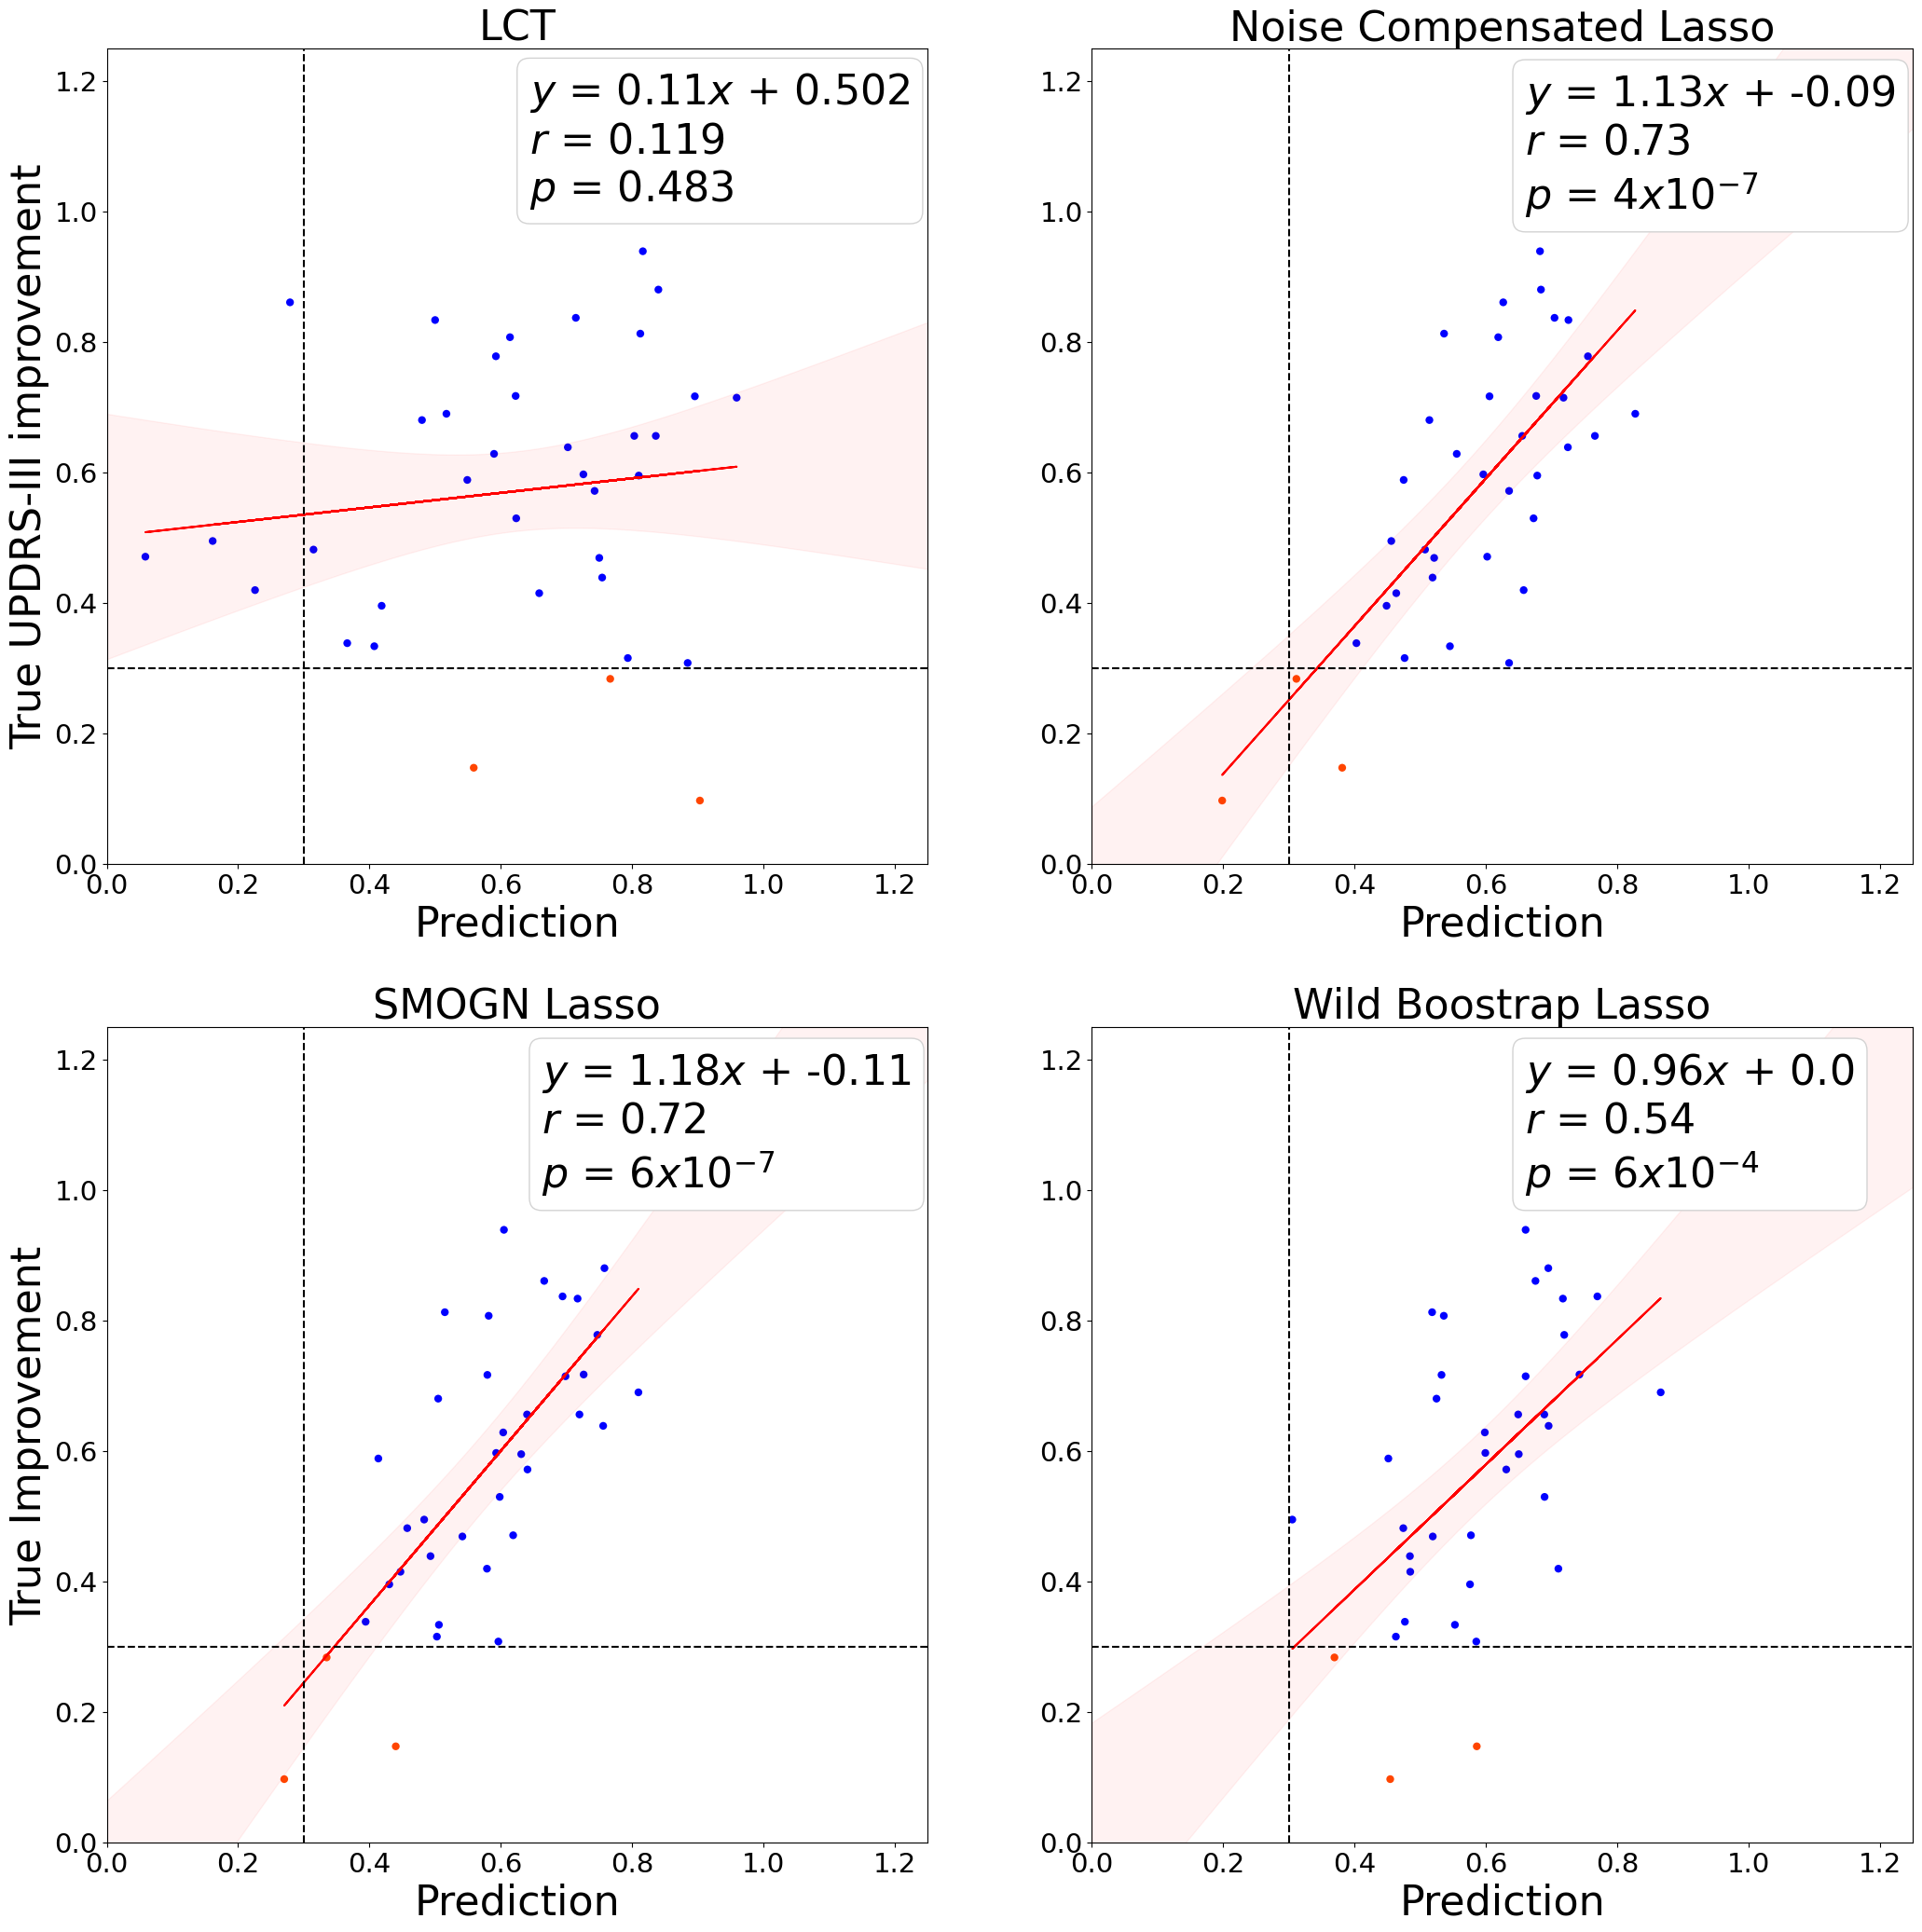

In [17]:
ylim = 1.25
fs = 32
ofx = 0.515
ofy = 0.8
pre_imp = (np.asarray(pre_updrs_iii_off,dtype=float)-np.asarray(pre_updrs_iii_on,dtype=float))/np.asarray(pre_updrs_iii_off,dtype=float)
plt.rcParams['figure.figsize'] = [25, 25]
fig,ax = plt.subplots(2,2,sharex=True,sharey=True)
col = np.where(per_change <= 0.3,'orangered','blue')
ax[0,0].scatter(pre_imp,per_change, c=col,linewidth=0)
lr = stats.linregress(pre_imp,per_change)
y_model = pre_imp*lr.slope+lr.intercept
ax[0,0].plot(pre_imp,y_model,color='r')
ci,pi,x_line,y_line = util.confidence_interval(pre_imp,per_change,ylim)
ax[0,0].fill_between(x_line, (y_line+ci), (y_line-ci), color='r', alpha=0.05)
ax[0,0].text(ofx,ofy,'$y$ = '+str(np.round(lr.slope,2))+'$x$ + '+str(np.round(lr.intercept,3))+'\n'+'$r$ = '+str(np.round(lr.rvalue,3))+'\n'+'$p$ = '+str(('{:.3f}'.format(lr.pvalue))),
                    ha='left', va='bottom', transform=ax[0,0].transAxes,fontsize=fs,
                    bbox=dict(facecolor='white', edgecolor='lightgray', boxstyle='round')) 
ax[0,0].hlines(0.3,0,2,linestyle='dashed',color='black')
ax[0,0].vlines(0.3,0,2,linestyle='dashed',color='black')
ax[0,0].set_title('LCT',fontsize=fs)
ax[0,0].set_xlabel('Prediction',fontsize=fs)
ax[0,0].xaxis.set_tick_params(labelleft=True,labelsize=fs//1.5)
ax[0,0].set_xlim([0,ylim])
ax[0,0].set_ylabel('True UPDRS-III improvement',fontsize=fs)
ax[0,0].yaxis.set_tick_params(labelleft=True,labelsize=fs//1.5)
ax[0,0].set_ylim([0,ylim])

ax[0,1].scatter(np.median(results_ls_aug,axis=0),per_change, c=col,linewidth=0)
lr = stats.linregress(np.squeeze(np.median(results_ls_aug,axis=0)),per_change)
y_model = np.median(results_ls_aug,axis=0)*lr.slope+lr.intercept
ax[0,1].plot(np.median(results_ls_aug,axis=0),y_model,color='r')
ci,pi,x_line,y_line = util.confidence_interval(np.median(results_ls_aug,axis=0),per_change,ylim)
ax[0,1].fill_between(x_line,y_line+ci,y_line-ci,color = 'r',label = '95% confidence interval',alpha=0.05)
pl = r'$'+latex_sci(lr.pvalue,0)+'$'
ax[0,1].text(ofx+0.013,ofy-0.01,'$y$ = '+str(np.round(lr.slope,2))+'$x$ + '+str(np.round(lr.intercept,2))+'\n'+'$r$ = '+str(np.round(lr.rvalue,2))+'\n'+'$p$ = '+pl,
                    ha='left', va='bottom', transform=ax[0,1].transAxes,fontsize=fs,
                    bbox=dict(facecolor='white', edgecolor='lightgray', boxstyle='round')) 
ax[0,1].hlines(0.3,0,2,linestyle='dashed',color='black')
ax[0,1].vlines(0.3,0,2,linestyle='dashed',color='black')
ax[0,1].set_title('Noise Compensated Lasso',fontsize=fs)
ax[0,1].set_xlabel('Prediction',fontsize=fs)
ax[0,1].xaxis.set_tick_params(labelleft=True,labelsize=fs//1.5)
ax[0,1].yaxis.set_tick_params(labelleft=True,labelsize=fs//1.5)

ax[1,0].scatter(np.median(results_ls_smogn,axis=0),per_change, c=col,linewidth=0)
lr = stats.linregress(np.squeeze(np.median(results_ls_smogn,axis=0)),per_change)
y_model = np.median(results_ls_smogn,axis=0)*lr.slope+lr.intercept
ax[1,0].plot(np.median(results_ls_smogn,axis=0),y_model,color='r')
ci,pi,x_line,y_line = util.confidence_interval(np.median(results_ls_smogn,axis=0),per_change,ylim)
ax[1,0].fill_between(x_line,y_line+ci,y_line-ci,color = 'r',label = '95% confidence interval',alpha=0.05)
pl = r'$'+latex_sci(lr.pvalue,0)+'$'
ax[1,0].text(ofx+0.015,ofy-0.01,'$y$ = '+str(np.round(lr.slope,2))+'$x$ + '+str(np.round(lr.intercept,2))+'\n'+'$r$ = '+str(np.round(lr.rvalue,2))+'\n'+'$p$ = '+pl,
                    ha='left', va='bottom', transform=ax[1,0].transAxes,fontsize=fs,
                    bbox=dict(facecolor='white', edgecolor='lightgray', boxstyle='round')) 
ax[1,0].hlines(0.3,0,2,linestyle='dashed',color='black')
ax[1,0].vlines(0.3,0,2,linestyle='dashed',color='black')
ax[1,0].set_xlabel('Prediction',fontsize=fs)
ax[1,0].xaxis.set_tick_params(labelleft=True,labelsize=fs//1.5)
ax[1,0].set_ylabel('True Improvement',fontsize=fs)
ax[1,0].yaxis.set_tick_params(labelleft=True,labelsize=fs//1.5)
ax[1,0].set_title('SMOGN Lasso',fontsize=fs)

ax[1,1].scatter(np.median(results_ls_wbs,axis=0),per_change, c=col,linewidth=0)
lr = stats.linregress(np.squeeze(np.median(results_ls_wbs,axis=0)),per_change)
y_model = np.median(results_ls_wbs,axis=0)*lr.slope+lr.intercept
ax[1,1].plot(np.median(results_ls_wbs,axis=0),y_model,color='r')
ci,pi,x_line,y_line = util.confidence_interval(np.median(results_ls_wbs,axis=0),per_change,ylim)
ax[1,1].fill_between(x_line,y_line+ci,y_line-ci,color = 'r',label = '95% confidence interval',alpha=0.05)
pl = r'$'+latex_sci(lr.pvalue,0)+'$'
ax[1,1].text(ofx+0.013,ofy-0.01,'$y$ = '+str(np.round(lr.slope,2))+'$x$ + '+str(np.round(lr.intercept,2))+'\n'+'$r$ = '+str(np.round(lr.rvalue,2))+'\n'+'$p$ = '+pl,
                    ha='left', va='bottom', transform=ax[1,1].transAxes,fontsize=fs,
                    bbox=dict(facecolor='white', edgecolor='lightgray', boxstyle='round')) 

ax[1,1].hlines(0.3,0,2,linestyle='dashed',color='black')
ax[1,1].vlines(0.3,0,2,linestyle='dashed',color='black')
ax[1,1].set_xlabel('Prediction',fontsize=fs)
ax[1,1].xaxis.set_tick_params(labelleft=True,labelsize=fs//1.5)
ax[1,1].yaxis.set_tick_params(labelleft=True,labelsize=fs//1.5)
ax[1,1].set_title('Wild Boostrap Lasso',fontsize=fs)

plt.style.use('default')

In [22]:
import scipy

In [23]:
def rec(res,pc):
        y_true = pc
        y_pred = res
        epsilon_0 = 0.0
        epsilon_max = 1.0
        d_epsilon = 0.05
        y = []
        x = np.arange(epsilon_0,epsilon_max,d_epsilon)
        epsilon = np.abs(y_true-y_pred) 
        for j in np.arange(len(x)):
            c = 0
            for k in np.arange(len(epsilon)):
                if epsilon[k] < x[j]:
                    c = c+1
            y.append(c/len(y_true))
        auc_rec = scipy.integrate.simps(y,x)/epsilon_max
        return x, np.array(y), auc_rec



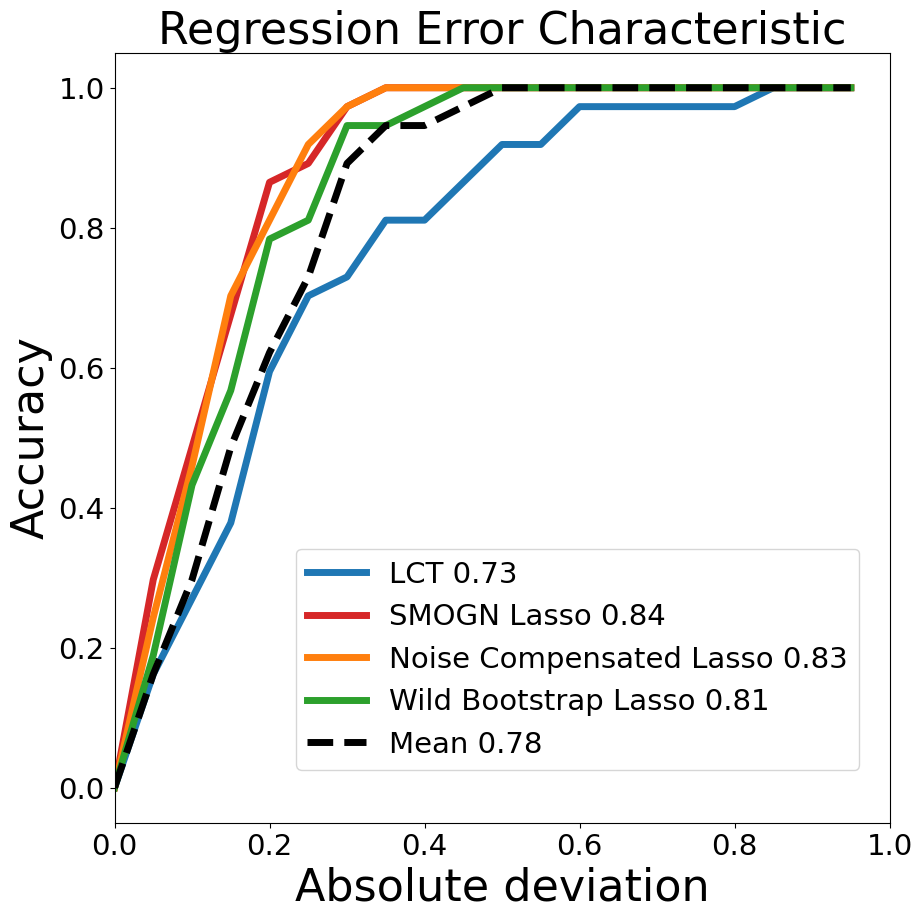

In [24]:
plt.rcParams["figure.figsize"] = (10,10)
fig,ax = plt.subplots(1,1,sharex=True,sharey=True)
x_lct,y_lct,eta = rec(pre_imp,per_change)
plt.plot(x_lct,y_lct,linewidth=5,label='LCT %0.2f' % eta, color='tab:blue')
# x_ls,y_ls,a,eta = rec(results_ls,per_change)
# plt.plot(x_ls,y_ls,label='Lasso %0.2f' % eta)
# x_ls,y_ls,eta = rec(results_lsw,per_change)
# plt.plot(x_ls,y_ls,linewidth=5,label='Bootstrap Lasso %0.3f' % eta, color='tab:blue')
x_smogn,y_smogn,eta = rec(np.median(results_ls_smogn,axis=0),per_change)
plt.plot(x_smogn,y_smogn,linewidth=5,label='SMOGN Lasso %0.2f' % eta, color='tab:red')
x_lsa,y_lsa,eta = rec(np.median(results_ls_aug,axis=0),per_change)
plt.plot(x_lsa,y_lsa,linewidth=5,label='Noise Compensated Lasso %0.2f' % eta, color='tab:orange')
x_wbs,y_wbs,eta = rec(np.median(results_ls_wbs,axis=0),per_change)
plt.plot(x_wbs,y_wbs,linewidth=5,label='Wild Bootstrap Lasso %0.2f' % eta, color="tab:green")
x_n,y_n,eta = rec(np.median(per_change)*np.ones_like(per_change),per_change)
plt.plot(x_n,y_n,linestyle='dashed',color='k',linewidth=5,label='Mean %0.2f' % eta)
plt.xlabel('Absolute deviation',fontsize=fs)
plt.ylabel('Accuracy',fontsize=fs)
plt.xlim([0,1])
plt.title('Regression Error Characteristic',fontsize=fs)
ax.xaxis.set_tick_params(labelleft=True,labelsize=fs//1.5)
ax.yaxis.set_tick_params(labelleft=True,labelsize=fs//1.5)
ax.legend(bbox_to_anchor=(0.215,0.375),fontsize=fs//1.5)


In [25]:
res = scipy.stats.wilcoxon(np.median(results_ls_aug,axis=0),np.median(results_ls_smogn,axis=0))
res.pvalue

0.2944097491066251